## Imports

In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import missingno as msno
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
pd.set_option('display.max_columns', None)
from sktime.forecasting.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import seaborn as sns
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX as StatsmodelsSARIMAX
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import random
import tensorflow as tf

In [2]:
#surpress warnings

warnings.filterwarnings("ignore")

In [3]:
random.seed(19)
tf.random.set_seed(19)

## Data Loading

In [4]:
def load_data(path):
    df = pd.read_csv(path, parse_dates=['datetime'])
    df = df.sort_index()
    columns_to_drop = ['Unnamed: 0', 'sunrise', 'sunset']
    df = df.drop(columns=columns_to_drop)
    df['datetime'] = pd.to_datetime(df['datetime'])

    last_year = df['datetime'].max() - pd.DateOffset(years=1)
    df_last_year = df[df['datetime'] >= last_year]
    df = df.sort_values('datetime')
    
    return df, df_last_year


In [5]:
df_lima, df_last_year_lima = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\lima_weather_2014-2024.csv')

In [6]:
df_lima.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,conditions,description,icon,stations
0,"Lima, PerÃº",2014-01-01,25.0,19.0,21.4,25.0,19.0,21.4,18.3,82.7,0.0,0,0.0,NaN,NaN,NaN,NaN,22.3,178.0,1011.8,67.9,9.1,206.9,17.8,6,NaN,0.00,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,SPIM
1,"Lima, PerÃº",2014-01-02,25.0,19.0,21.6,25.0,19.0,21.6,18.6,83.6,0.0,0,0.0,NaN,NaN,NaN,NaN,29.5,170.3,1010.8,60.5,10.0,271.7,23.3,9,NaN,0.04,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,SPIM
2,"Lima, PerÃº",2014-01-03,25.0,20.0,21.5,25.0,20.0,21.5,18.5,83.4,0.0,0,0.0,NaN,NaN,NaN,NaN,18.4,192.4,1010.1,79.4,9.0,299.7,25.7,10,NaN,0.08,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"SPIM,remote"
3,"Lima, PerÃº",2014-01-04,24.0,20.0,21.4,24.0,20.0,21.4,18.8,85.5,0.0,0,0.0,NaN,NaN,NaN,NaN,16.6,182.5,1010.6,62.1,8.8,272.0,23.5,10,NaN,0.11,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,SPIM
4,"Lima, PerÃº",2014-01-05,25.0,20.0,22.1,25.0,20.0,22.1,19.2,83.8,0.0,0,0.0,NaN,NaN,NaN,NaN,25.9,165.5,1011.0,71.4,10.0,274.9,23.7,9,NaN,0.14,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"SPIM,remote"


## Stationarity Test

In [7]:
def test_stationarity(df):
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print('TS is stationary')
    else:
        print('TS not stationary')

In [8]:
test_stationarity(df_lima['temp'])

ADF Statistic: -4.390477313835978
p-value: 0.0003085654375653975
TS is stationary


In [9]:
df_lima.head(2)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,conditions,description,icon,stations
0,"Lima, PerÃº",2014-01-01,25.0,19.0,21.4,25.0,19.0,21.4,18.3,82.7,0.0,0,0.0,NaN,NaN,NaN,NaN,22.3,178.0,1011.8,67.9,9.1,206.9,17.8,6,NaN,0.00,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,SPIM
1,"Lima, PerÃº",2014-01-02,25.0,19.0,21.6,25.0,19.0,21.6,18.6,83.6,0.0,0,0.0,NaN,NaN,NaN,NaN,29.5,170.3,1010.8,60.5,10.0,271.7,23.3,9,NaN,0.04,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,SPIM


## Heatmap

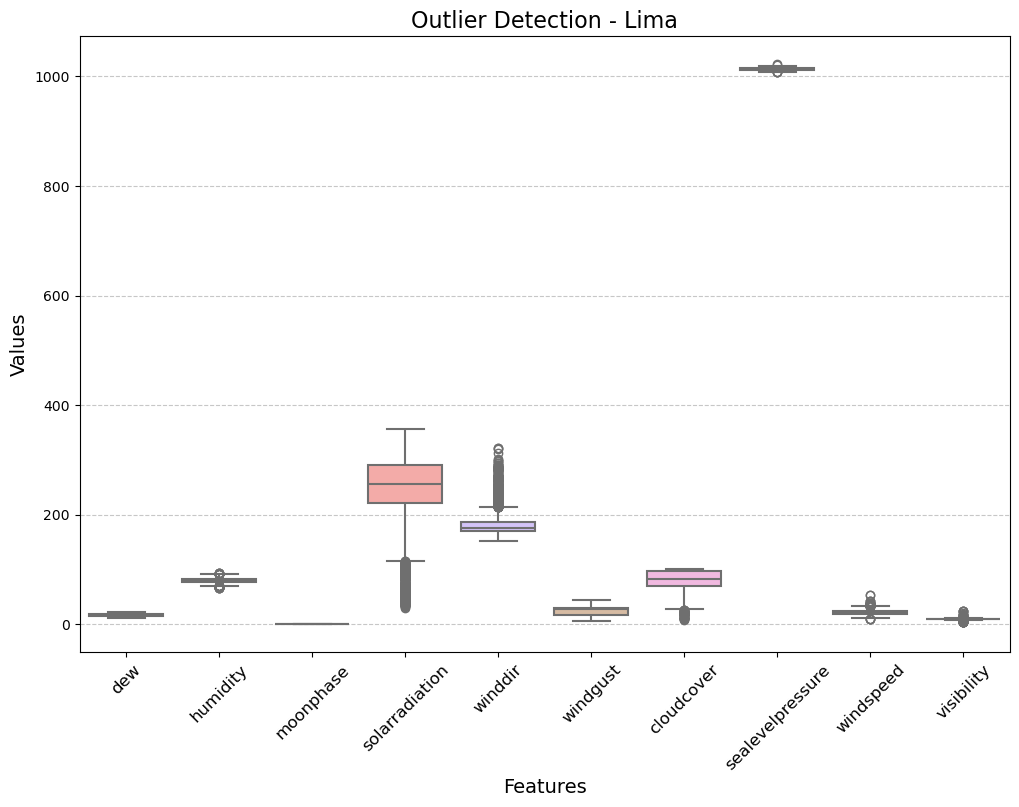

In [10]:
#checking for outliers

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_lima[['dew', 'humidity', 'moonphase', 'solarradiation', 'winddir', 'windgust','cloudcover','sealevelpressure','windspeed','visibility']], 
             palette='pastel', linewidth=1.5)
plt.title("Outlier Detection - Lima", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\outlier_check-lima.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [11]:
#creating the correlation between features, for feature importance later on and heatmap
df_lima_heatmap = df_lima.drop(['name', 'preciptype', 'conditions','description','icon', 'stations'],axis=1)

In [12]:
corr_matrix = df_lima_heatmap.corr()
print(corr_matrix) 

                  datetime   tempmax   tempmin      temp  feelslikemax  \
datetime          1.000000 -0.061833 -0.006098 -0.028513     -0.066052   
tempmax          -0.061833  1.000000  0.920286  0.973849      0.991627   
tempmin          -0.006098  0.920286  1.000000  0.973570      0.917494   
temp             -0.028513  0.973849  0.973570  1.000000      0.968479   
feelslikemax     -0.066052  0.991627  0.917494  0.968479      1.000000   
feelslikemin     -0.006098  0.920286  1.000000  0.973570      0.917494   
feelslike        -0.030760  0.973408  0.972281  0.998981      0.972743   
dew              -0.130185  0.926985  0.931618  0.954132      0.924826   
humidity         -0.285313 -0.490415 -0.487388 -0.502734     -0.478142   
precip            0.056970  0.212262  0.195890  0.205701      0.214848   
precipprob        0.211312  0.346039  0.344930  0.350046      0.354076   
precipcover      -0.030773  0.350475  0.327024  0.343448      0.371454   
snow                   NaN       NaN  

In [15]:
# #understanding monthly distribution of the data and how the temperature differ from month to month

# df_lima['month'] = df_lima.index.month

# plt.figure(figsize=(12, 6))
# sns.boxplot(x='month', y='temp', data=df_lima, palette='viridis', linewidth=1.5)
# plt.title('Monthly Temperature Distribution - Lima', fontsize=16)
# plt.xlabel('Month', fontsize=14)
# plt.ylabel('Temperature (°C)', fontsize=14)
# plt.xticks(fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\targetfeature_distribution_lima.png'
# plt.savefig(save_path, bbox_inches='tight', dpi=300) 

# plt.show()

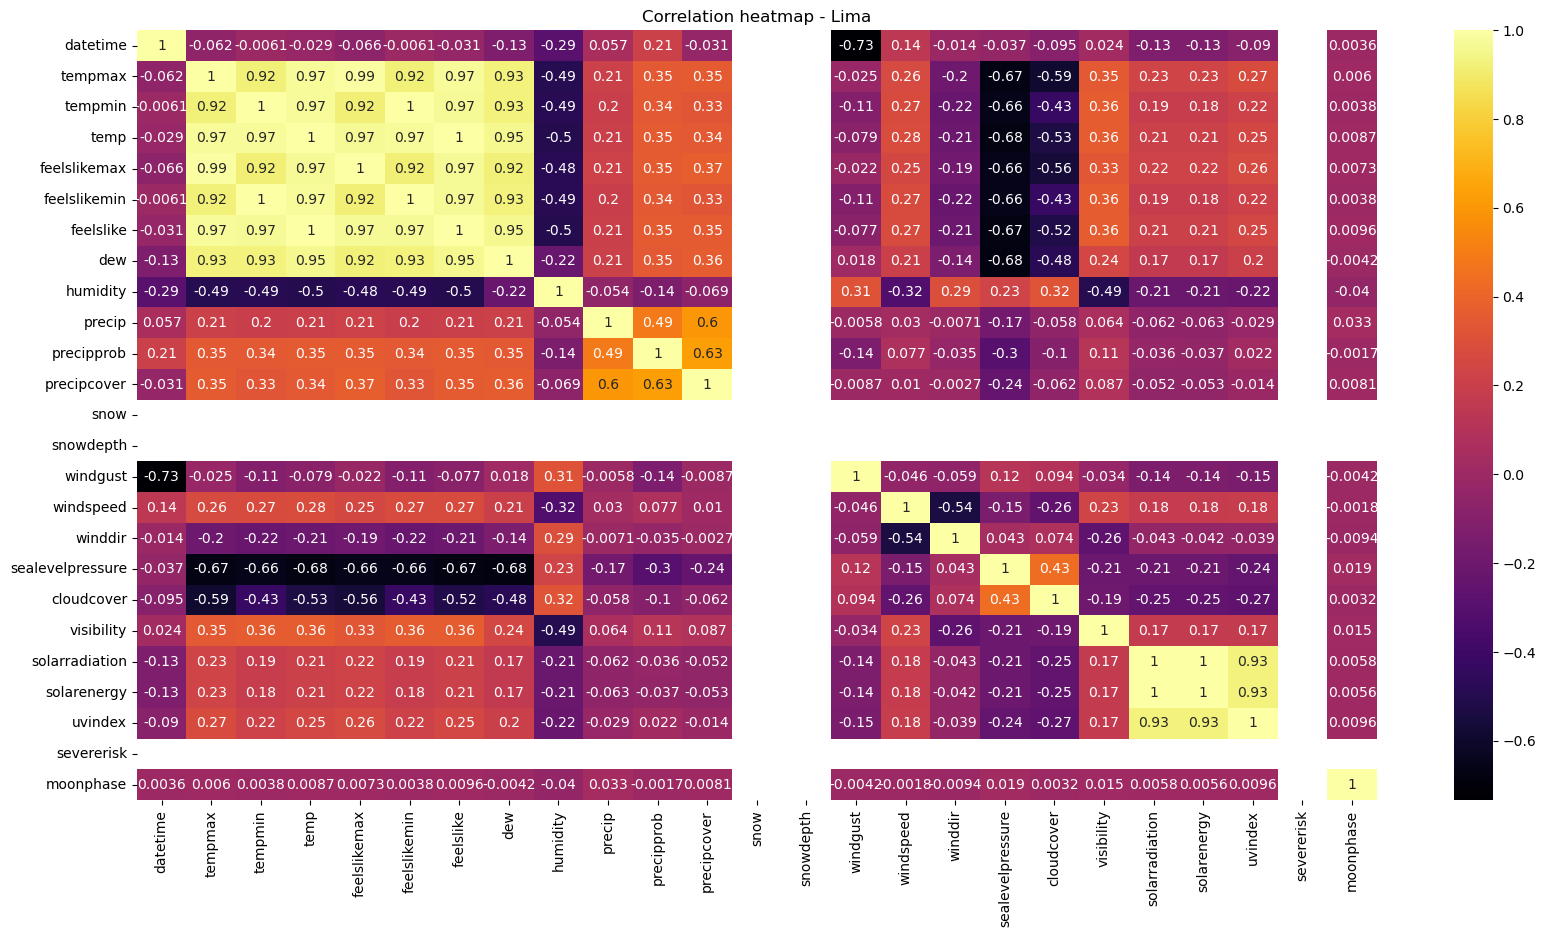

In [16]:
#heatmap

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='inferno')
plt.title("Correlation heatmap - Lima")

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\heatmap_lima.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 


plt.show()

## Missing values

In [17]:
df_lima.set_index("datetime", inplace = True)
df_lima.sort_index(inplace = True)

In [18]:
df_lima.index = pd.to_datetime(df_lima.index)

In [19]:
df_lima.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          2957
snow                 365
snowdepth            364
windgust             363
windspeed              0
winddir                0
sealevelpressure     328
cloudcover             0
visibility            11
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2931
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

In [20]:
imputer = KNNImputer(n_neighbors=5)
df_lima[['windgust', 'severerisk', 'sealevelpressure', 'visibility']] = imputer.fit_transform(df_lima[['windgust', 'severerisk', 'sealevelpressure', 'visibility']])

In [21]:
df_lima['snowdepth'].fillna(0, inplace=True)

In [22]:
df_lima['snow'].fillna(0, inplace=True)

In [23]:
df_lima.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          2957
snow                   0
snowdepth              0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk             0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

In [24]:
columns_to_drop = ['tempmax', 'tempmin', 'icon', 'stations', 'conditions', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'preciptype', 'name']
df_lima = df_lima.drop(columns=columns_to_drop)

## Tokenization

In [25]:
# step 1: text processing
tokenizer = CountVectorizer()
hashingTF = TfidfTransformer(use_idf=False)
idf = TfidfTransformer(use_idf=True)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

In [26]:
# pipeline that processes text and then clusters
pipeline = Pipeline(steps=[
    ('tokenizer', tokenizer),
    ('hashingTF', hashingTF),
    ('idf', idf),
    ('kmeans', kmeans)
])

In [27]:
# fitting the model on the "description"column
text_features = pipeline.fit_transform(df_lima['description'])

In [28]:
kmeans.labels_
df_lima['clusters_description'] = kmeans.labels_

In [29]:
df_lima['clusters_description'].value_counts()

clusters_description
0    1546
1    1293
2     954
Name: count, dtype: int64

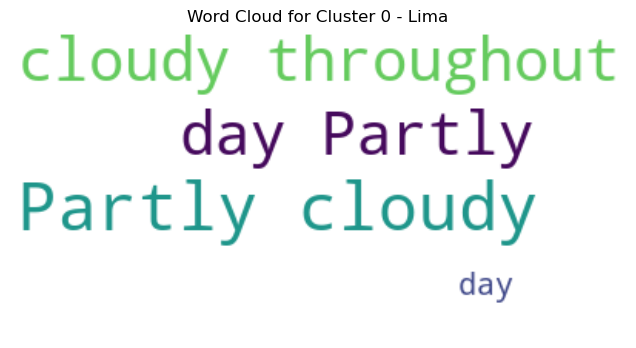

In [30]:
text = ' '.join(description for description in df_lima[df_lima['clusters_description']==0]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 0 - Lima')

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_0-lima.png'
plt.savefig(save_path, bbox_inches='tight') 
plt.show()

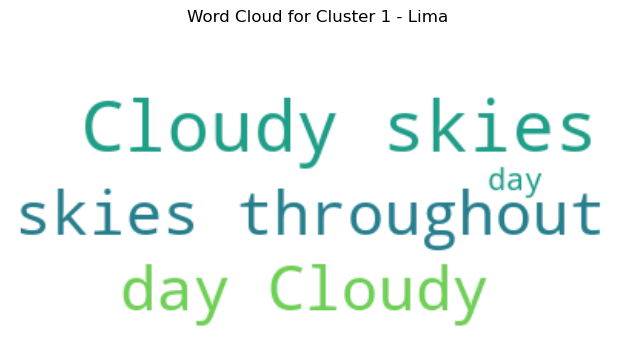

In [31]:
text = ' '.join(description for description in df_lima[df_lima['clusters_description']==1]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 1 - Lima')
save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_1-lima.png'
plt.savefig(save_path, bbox_inches='tight') 
plt.show()

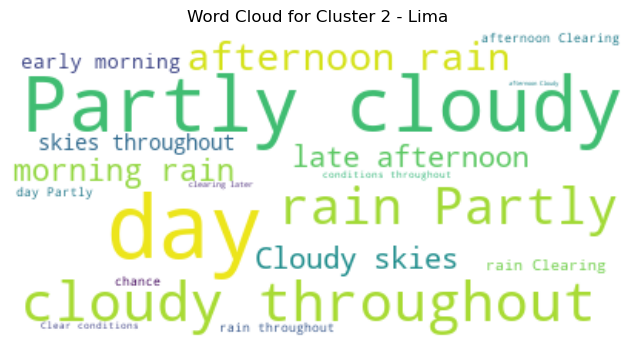

In [32]:
text = ' '.join(description for description in df_lima[df_lima['clusters_description']==2]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 2 - Lima')
save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_2-Lima.png'
plt.savefig(save_path, bbox_inches='tight') 
plt.show()

In [33]:
df_lima = df_lima.drop(columns=['description'])
df_lima.head(5)

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description
datetime,,,,,,,,,,,,,,,,,,,,
2014-01-01,21.4,18.3,82.7,0.0,0,0.0,0.0,0.0,13.62,22.3,178.0,1011.8,67.9,9.1,206.9,17.8,6,10.0,0.00,0
2014-01-02,21.6,18.6,83.6,0.0,0,0.0,0.0,0.0,23.46,29.5,170.3,1010.8,60.5,10.0,271.7,23.3,9,10.0,0.04,0
2014-01-03,21.5,18.5,83.4,0.0,0,0.0,0.0,0.0,23.60,18.4,192.4,1010.1,79.4,9.0,299.7,25.7,10,10.0,0.08,0
2014-01-04,21.4,18.8,85.5,0.0,0,0.0,0.0,0.0,26.64,16.6,182.5,1010.6,62.1,8.8,272.0,23.5,10,10.0,0.11,0
2014-01-05,22.1,19.2,83.8,0.0,0,0.0,0.0,0.0,23.28,25.9,165.5,1011.0,71.4,10.0,274.9,23.7,9,10.0,0.14,0


## Lagged features

In [34]:
# this shifts all features by three days except the temp, and then it merges them back togther
df_lima_shifted = df_lima.drop('temp', axis=1).shift(3)

In [35]:
df_lima_eng = pd.concat([df_lima['temp'], df_lima_shifted], axis=1)

In [36]:
df_lima_eng.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description
datetime,,,,,,,,,,,,,,,,,,,,
2014-01-01,21.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,21.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,21.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,21.4,18.3,82.7,0.0,0.0,0.0,0.0,0.0,13.62,22.3,178.0,1011.8,67.9,9.1,206.9,17.8,6.0,10.0,0.00,0.0
2014-01-05,22.1,18.6,83.6,0.0,0.0,0.0,0.0,0.0,23.46,29.5,170.3,1010.8,60.5,10.0,271.7,23.3,9.0,10.0,0.04,0.0


In [37]:
df_lima_shifted.head()

,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description
datetime,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,18.3,82.7,0.0,0.0,0.0,0.0,0.0,13.62,22.3,178.0,1011.8,67.9,9.1,206.9,17.8,6.0,10.0,0.00,0.0
2014-01-05,18.6,83.6,0.0,0.0,0.0,0.0,0.0,23.46,29.5,170.3,1010.8,60.5,10.0,271.7,23.3,9.0,10.0,0.04,0.0


In [38]:
# adding back the last three rows, which have all the shifted features but without the temp for them as that is what we predict
last_three = df_lima_shifted.tail(3)
last_three.set_index( pd.date_range(start=max(df_lima.index)+pd.Timedelta(days=1), periods=3, freq='D'))


,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description
2024-05-21,15.4,81.5,0.0,0.0,0.0,0.0,0.0,9.7,18.4,194.4,1013.6,73.6,9.0,240.5,20.9,8.0,10.0,0.25,0.0
2024-05-22,15.9,82.3,0.0,0.0,0.0,0.0,0.0,11.5,20.5,175.4,1013.1,49.1,7.5,237.9,20.6,8.0,10.0,0.28,0.0
2024-05-23,15.7,88.5,0.0,0.0,0.0,0.0,0.0,13.3,24.1,172.3,1013.9,90.4,5.7,208.1,18.1,8.0,10.0,0.31,1.0


In [39]:
max(df_lima.index)+pd.Timedelta(days=1)

Timestamp('2024-05-21 00:00:00')

In [40]:
df_lima_final = pd.concat([df_lima_eng, last_three], ignore_index=True)

In [41]:
df_lima_final = df_lima_final.set_index(pd.date_range(start=min(df_lima.index), periods=len(df_lima)+3, freq='D'))

In [42]:
df_lima_final.tail()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description
2024-05-19,17.3,15.9,82.3,0.0,0.0,0.0,0.0,0.0,11.5,20.5,175.4,1013.1,49.1,7.5,237.9,20.6,8.0,10.0,0.28,0.0
2024-05-20,16.9,15.7,88.5,0.0,0.0,0.0,0.0,0.0,13.3,24.1,172.3,1013.9,90.4,5.7,208.1,18.1,8.0,10.0,0.31,1.0
2024-05-21,NaN,15.4,81.5,0.0,0.0,0.0,0.0,0.0,9.7,18.4,194.4,1013.6,73.6,9.0,240.5,20.9,8.0,10.0,0.25,0.0
2024-05-22,NaN,15.9,82.3,0.0,0.0,0.0,0.0,0.0,11.5,20.5,175.4,1013.1,49.1,7.5,237.9,20.6,8.0,10.0,0.28,0.0
2024-05-23,NaN,15.7,88.5,0.0,0.0,0.0,0.0,0.0,13.3,24.1,172.3,1013.9,90.4,5.7,208.1,18.1,8.0,10.0,0.31,1.0


In [43]:
df_lima_final['month'] = df_lima_final.index.month
df_lima_final['year'] = df_lima_final.index.year

In [44]:
df_dummies = pd.get_dummies(df_lima_final['month'], prefix='month')

In [45]:
df_lima_final = pd.concat([df_lima_final, df_dummies], axis=1)
df_lima_final.drop(columns=['month'], inplace=True)

## Train and test split

In [46]:
df_train = df_lima_final.iloc[:-368] #training set - takes the last 368 days
df_test = df_lima_final.iloc[-368:-3] #test set - takes the last 368 - the last 3 days for preds
df_future =  df_lima_final.iloc[-3:] #future dataframe that contains the predictions that we will generate but right now jas just the features

In [47]:
df_train.head()
df_train.dropna(inplace=True)

## XGBoost

In [48]:
start_time = time.time()
model_baseline = XGBRegressor()
model_baseline.fit(df_train.drop('temp',axis=1), df_train[['temp']])
end_time = time.time()

#calculates the time taken for each model to compute
time_xgboost_baseline = end_time - start_time
print(f"Model execution time for XGBoost baseline for LIMA: {time_xgboost_baseline:.4f} seconds")

Model execution time for XGBoost baseline for LIMA: 0.6817 seconds


In [49]:
y_pred_xgboost = model_baseline.predict(df_test.drop('temp',axis=1))

In [50]:
y_pred_xgboost

array([22.20442 , 22.350317, 22.70992 , 22.468319, 22.85678 , 21.636263,
       21.704062, 22.009914, 22.783413, 21.672527, 22.50217 , 21.797527,
       21.973227, 21.530087, 22.480747, 21.766964, 21.884071, 22.142508,
       22.30094 , 22.724743, 22.81998 , 22.36538 , 22.447191, 21.456915,
       20.212143, 20.579466, 21.412384, 21.48776 , 21.8894  , 21.314634,
       20.505205, 19.994951, 21.07412 , 21.29777 , 20.52525 , 19.65667 ,
       20.254915, 20.39986 , 21.61802 , 21.405825, 20.359236, 20.331247,
       19.958513, 20.08216 , 21.134129, 20.159908, 22.466106, 21.400927,
       20.777838, 20.84094 , 20.566547, 20.865932, 20.289062, 19.881742,
       20.368666, 20.910063, 20.851841, 19.703669, 19.86139 , 19.382683,
       19.67321 , 20.028292, 20.739798, 20.648037, 20.580223, 20.581003,
       20.443777, 20.116827, 20.03423 , 20.04541 , 20.276543, 20.436083,
       20.681925, 20.357548, 19.582182, 18.840357, 18.772678, 19.194592,
       18.80131 , 19.261463, 19.53528 , 20.18177 , 

In [51]:
has_na = np.isnan(y_pred_xgboost).any()
print({has_na})

{False}


In [52]:
na_count = np.isnan(y_pred_xgboost).sum()
print({na_count})

{0}


In [53]:
df_test.isna()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2023-05-22,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-23,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-25,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-26,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-17,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-19,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [54]:
mae = mean_absolute_error(df_test['temp'], y_pred_xgboost)
mse = mean_squared_error(df_test['temp'], y_pred_xgboost)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], y_pred_xgboost)

print(f"Mean Absolute Error (MAE) for XGBoost baseline with all regressors: {mae}")
print(f"Mean Squared Error (MSE) for XGBoost baseline with all regressors: {mse}")
print(f"Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: {rmse}")
print(f"R-squared (R2) for XGBoost baseline with all regressors: {r2}")

Mean Absolute Error (MAE) for XGBoost baseline with all regressors: 0.7982989240672492
Mean Squared Error (MSE) for XGBoost baseline with all regressors: 0.9987353625291505
Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: 0.9993674812245746
R-squared (R2) for XGBoost baseline with all regressors: 0.7929236640052847


In [55]:
df_preds_lima = df_test.copy() 

In [56]:
#create new column in order to attach index date to the preds
df_preds_lima['xgb_base_lima'] = y_pred_xgboost

In [57]:
def plot_forecast(actuals, predictions, model_name, save_path=None):
    plt.figure(figsize=(15, 10))

    plt.plot(actuals, label='Actuals', color='green', marker='o', markersize=5, linestyle='-', linewidth=2)
    plt.plot(predictions, label='Predictions', color='purple', marker='s', markersize=5, linestyle='-', linewidth=2)

    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Temperature', fontsize=14)
    plt.title(f'Predicted vs Actual Temperature - {model_name} - Lima', fontsize=16)

    plt.grid(True)
    plt.legend(fontsize=12)

    if save_path is not None:
        plt.savefig(f"{save_path}/{model_name}_predictions_lima.png", bbox_inches='tight', dpi=300)

    plt.show()

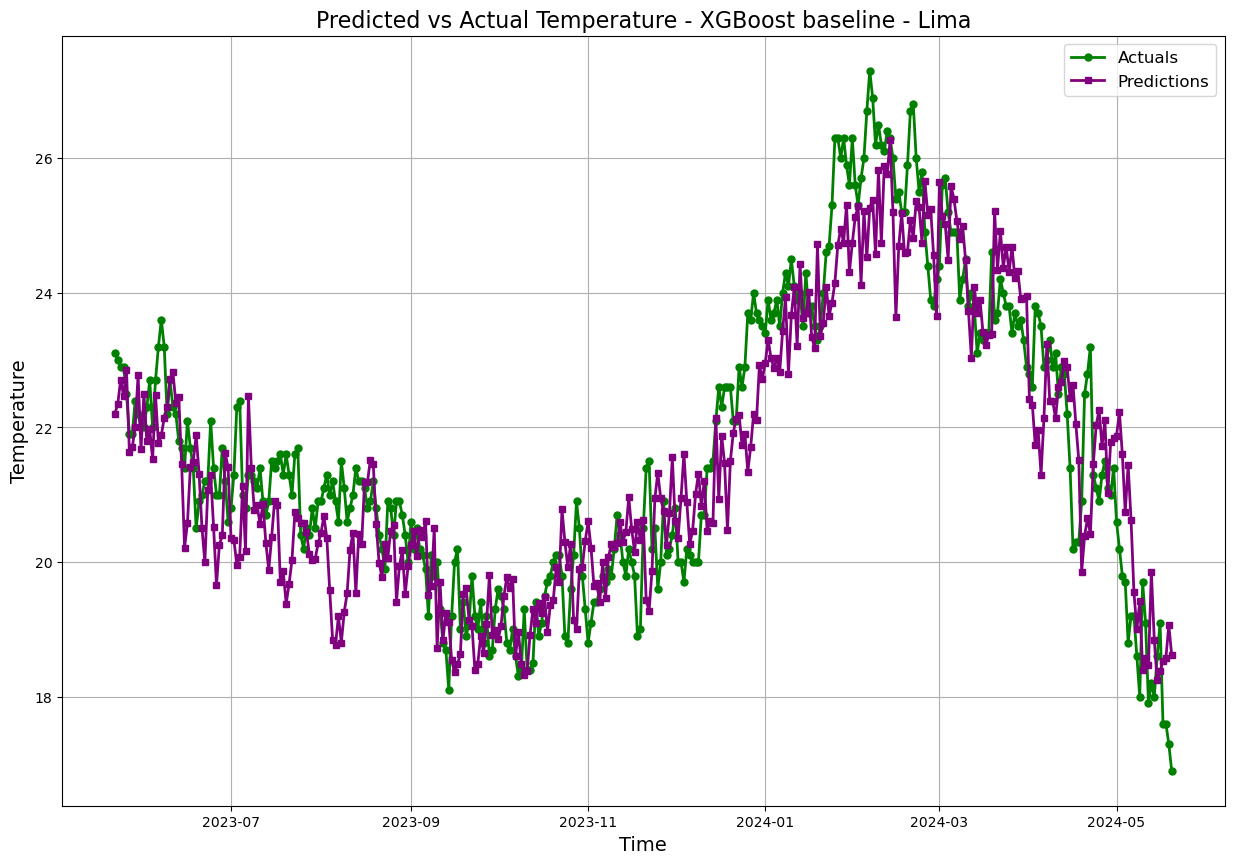

In [58]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['xgb_base_lima']], 'XGBoost baseline', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

<Figure size 1200x800 with 0 Axes>

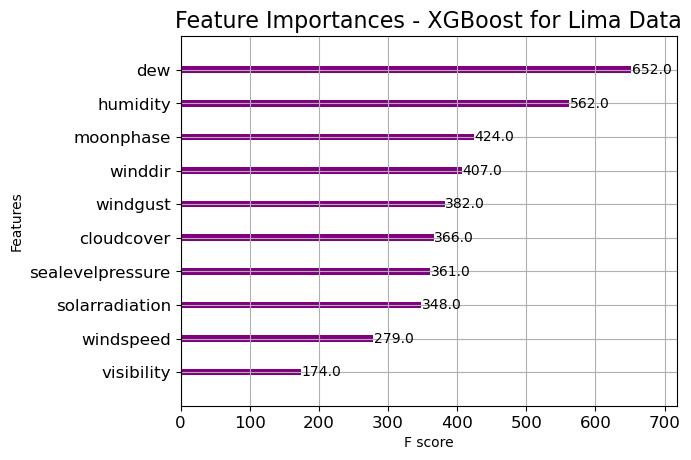

In [59]:
plt.figure(figsize=(12, 8))
plot_importance(model_baseline, 
                importance_type='weight', 
                max_num_features=10, 
                title='Feature Importances - XGBoost for Lima Data', 
                xlabel='F score', 
                ylabel='Features', 
                grid=True,
                color='purple')

plt.title('Feature Importances - XGBoost for Lima Data', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\feature_importance_lima.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [60]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'max_leaf_nodes':  [0, 10, 20], 
    'reg_lambda': [0, 0.1, 1]
}

grid_search = GridSearchCV(estimator=model_baseline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [61]:
start_time = time.time()
grid_search.fit(df_train.drop('temp', axis=1), df_train['temp']) #first one is train without target, second one is just target

best_params = grid_search.best_params_
best_score = grid_search.best_score_
end_time = time.time()


time_xgboost_gs = end_time - start_time
print(f"Model execution time for XGBoost grid search: {time_xgboost_gs:.4f} seconds")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Model execution time for XGBoost grid search: 71.5368 seconds


In [62]:
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best score: -0.5800683491291125


In [63]:
gs_model = XGBRegressor(learning_rate= 0.1, max_depth= 3, subsample= 0.7, max_leaf_nodes=0, reg_lambda=1)
gs_model.fit(df_train.drop('temp',axis=1), df_train[['temp']])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaf_nodes=0,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [64]:
y_pred_xgboost_gs_lima = gs_model.predict(df_test.drop('temp',axis=1))

In [65]:
mae = mean_absolute_error(df_test['temp'], y_pred_xgboost_gs_lima)
mse = mean_squared_error(df_test['temp'], y_pred_xgboost_gs_lima)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], y_pred_xgboost_gs_lima)

print(f"Mean Absolute Error (MAE) for GS model: {mae}")
print(f"Mean Squared Error (MSE) for GS model: {mse}")
print(f"Root Mean Squared Error (RMSE) for GS model: {rmse}")
print(f"R-squared (R2) for XGBoost baseline GS model: {r2}")

Mean Absolute Error (MAE) for GS model: 0.6716215086636479
Mean Squared Error (MSE) for GS model: 0.7429966187614501
Root Mean Squared Error (RMSE) for GS model: 0.8619725162448337
R-squared (R2) for XGBoost baseline GS model: 0.8459481628046461


In [66]:
df_preds_lima['xgb_gs_lima'] = y_pred_xgboost_gs_lima

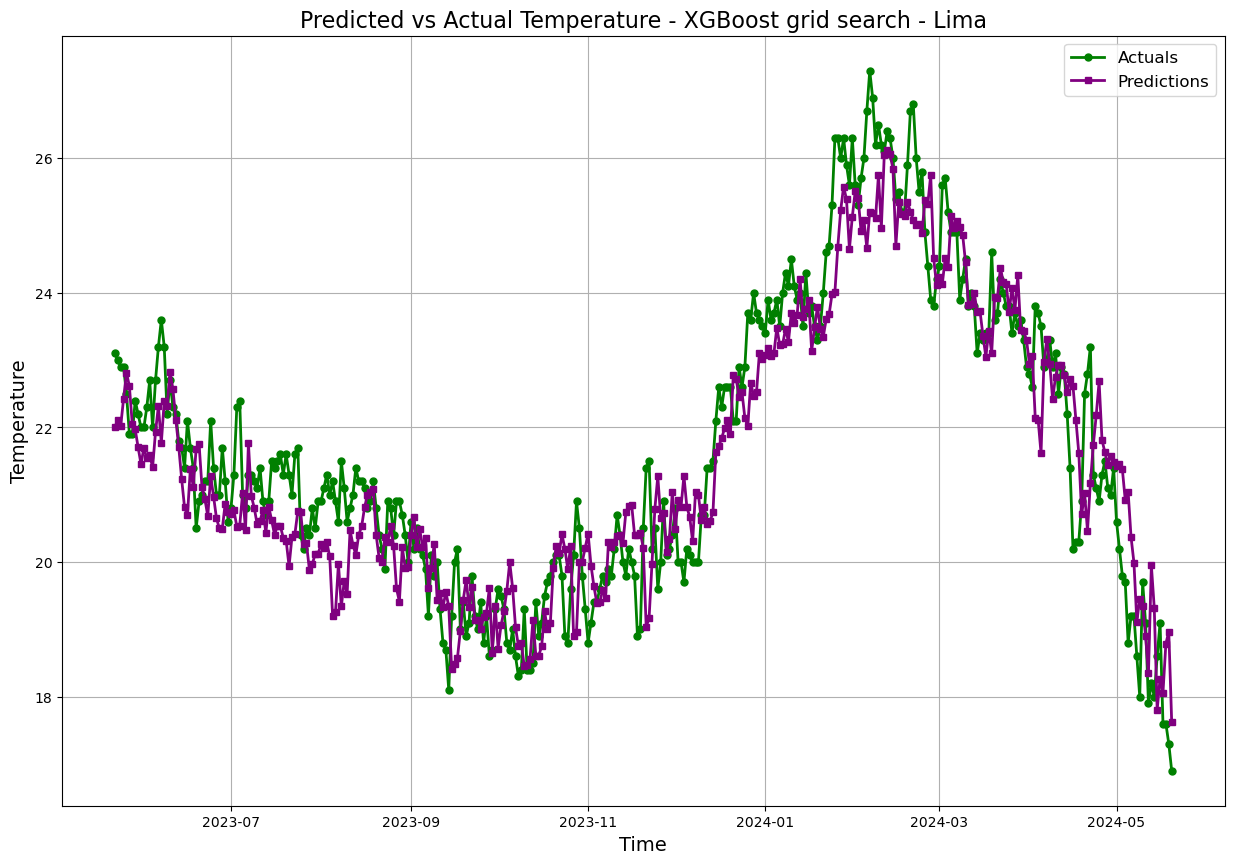

In [67]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['xgb_gs_lima']], 'XGBoost grid search', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

## Naive Forecaster

In [68]:
start_time = time.time()

forecaster_baseline_lima = NaiveForecaster(strategy="mean")
forecaster_baseline_lima.fit(df_train['temp'])

end_time = time.time()
time_naive_baseline_lima = end_time - start_time
print(f"Model execution time for Naive Forecaster baseline: {time_naive_baseline_lima:.4f} seconds")

Model execution time for Naive Forecaster baseline: 0.0053 seconds


In [69]:
y_pred_naiveforecaster = forecaster_baseline_lima.predict(df_test.index)

In [70]:
df_preds_lima['naive_base_lima'] = y_pred_naiveforecaster

In [71]:
df_preds_lima.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,xgb_base_lima,xgb_gs_lima,naive_base_lima
2023-05-22,23.1,17.0,70.9,0.1,100.0,4.17,0.0,0.0,13.3,27.7,152.5,1012.9,99.2,10.0,191.1,16.5,8.0,10.0,0.00,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.204420,22.007751,19.945401
2023-05-23,23.0,16.9,69.7,0.1,100.0,4.17,0.0,0.0,9.0,25.9,160.7,1012.8,99.2,10.0,192.5,16.5,8.0,10.0,0.03,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.350317,22.109001,19.945401
2023-05-24,22.9,17.3,73.6,0.0,0.0,0.00,0.0,0.0,10.8,24.1,161.1,1012.6,97.1,10.0,179.6,15.5,8.0,10.0,0.07,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.709921,22.018497,19.945401
2023-05-25,22.9,17.5,70.9,0.1,100.0,4.17,0.0,0.0,9.0,24.1,161.0,1012.4,97.5,9.5,151.9,13.2,7.0,10.0,0.10,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.468319,22.425869,19.945401
2023-05-26,22.5,17.8,72.6,0.1,100.0,4.17,0.0,0.0,11.2,25.9,161.7,1013.0,96.7,10.0,183.7,15.8,7.0,10.0,0.13,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.856779,22.813673,19.945401


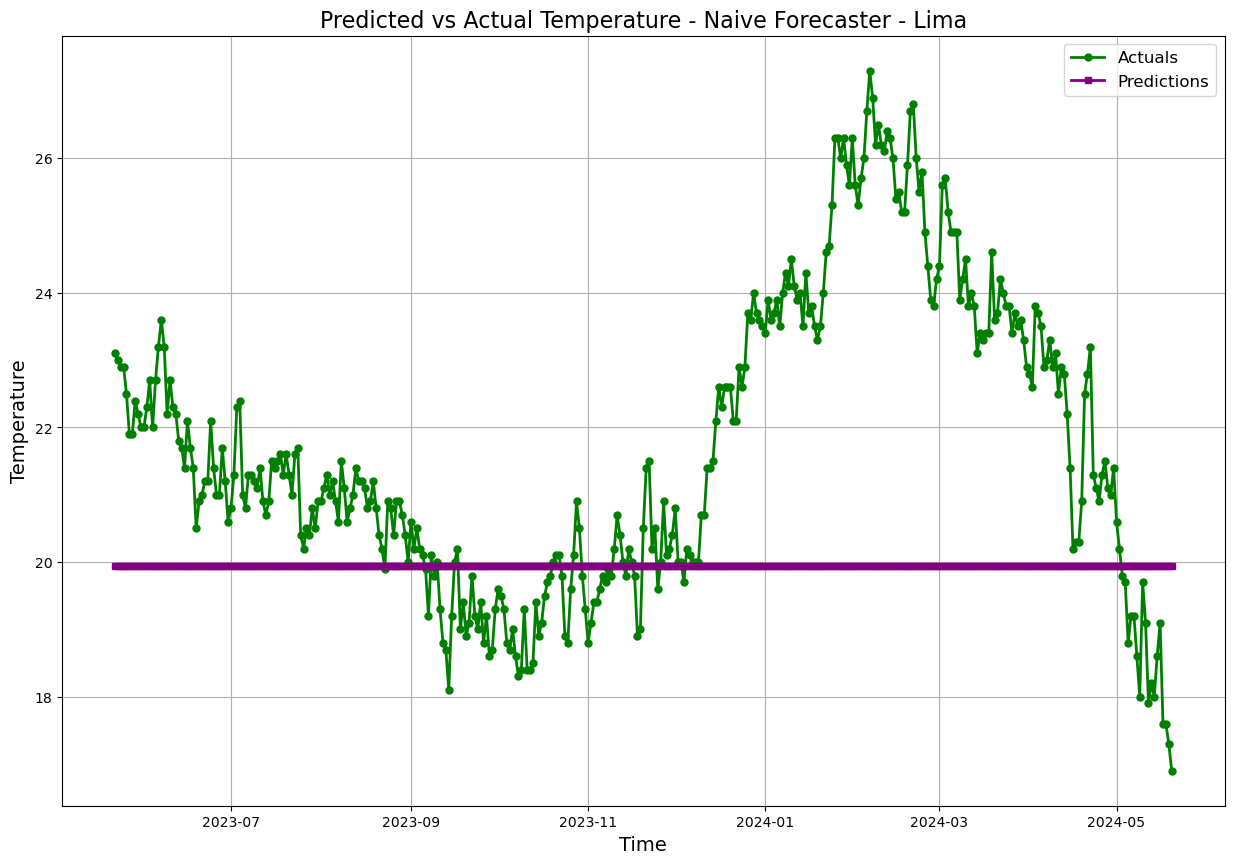

In [72]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['naive_base_lima']], 'Naive Forecaster', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

In [73]:
mae = mean_absolute_error(df_test['temp'], y_pred_naiveforecaster)
mse = mean_squared_error(df_test['temp'], y_pred_naiveforecaster)
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], y_pred_naiveforecaster)

print(f"Mean Absolute Error (MAE) for the Naive Forecaster: {mae}")
print(f"Mean Squared Error (MSE) for the Naive Forecaster: {mse}")
print(f"Root Mean Squared Error (RMSE) for the Naive Forecaster: {rmse}")
print(f"R-squared (R²) for the Naive Forecaster: {r2}")

Mean Absolute Error (MAE) for the Naive Forecaster: 2.1597060293970602
Mean Squared Error (MSE) for the Naive Forecaster: 7.951842954390691
Root Mean Squared Error (RMSE) for the Naive Forecaster: 2.8199012313183403
R-squared (R²) for the Naive Forecaster: -0.6487235409695982


In [74]:
def tune_naive(strategy): 
    start_time = time.time()
    forecaster_baseline = NaiveForecaster(strategy=strategy)
    forecaster_baseline.fit(df_train['temp'])
    y_pred_naiveforecaster_gs = forecaster_baseline.predict(df_test.index)
    # df_preds_lima['sktime_naive'] = y_pred_naiveforecaster_gs
    mae = mean_absolute_error(df_test['temp'], y_pred_naiveforecaster_gs)

    mse = mean_squared_error(df_test['temp'], y_pred_naiveforecaster_gs)
    rmse = np.sqrt(mse)
    r2 = r2_score(df_test['temp'], y_pred_naiveforecaster_gs)

    print(f"{strategy}, Mean Absolute Error (MAE) for the Naive Forecaster: {mae}")
    print(f"{strategy}, Mean Squared Error (MSE) for the Naive Forecaster: {mse}")
    print(f"{strategy}, Root Mean Squared Error (RMSE) for the Naive Forecaster: {rmse}")
    print(f"{strategy}, R-squared (R²) for the Naive Forecaster: {r2}")
    end_time = time.time()
    time_naive_gs = end_time - start_time
    print(f"Model execution time: {time_naive_gs:.4f} seconds")

In [75]:
tune_naive("mean")

mean, Mean Absolute Error (MAE) for the Naive Forecaster: 2.1597060293970602
mean, Mean Squared Error (MSE) for the Naive Forecaster: 7.951842954390691
mean, Root Mean Squared Error (RMSE) for the Naive Forecaster: 2.8199012313183403
mean, R-squared (R²) for the Naive Forecaster: -0.6487235409695982
Model execution time: 0.0334 seconds


In [76]:
tune_naive("last")

last, Mean Absolute Error (MAE) for the Naive Forecaster: 1.9517808219178086
last, Mean Squared Error (MSE) for the Naive Forecaster: 5.16613698630137
last, Root Mean Squared Error (RMSE) for the Naive Forecaster: 2.2729137656984197
last, R-squared (R²) for the Naive Forecaster: -0.07113932129227485
Model execution time: 0.0716 seconds


In [77]:
tune_naive("drift")

drift, Mean Absolute Error (MAE) for the Naive Forecaster: 1.9527061995903214
drift, Mean Squared Error (MSE) for the Naive Forecaster: 5.189912840356471
drift, Root Mean Squared Error (RMSE) for the Naive Forecaster: 2.2781380204799864
drift, R-squared (R²) for the Naive Forecaster: -0.0760689722564778
Model execution time: 0.0416 seconds


In [78]:
# the last strategy had the best result so the predictions will be included in the df with all predictions 
y_pred_naiveforecaster_gs = forecaster_baseline_lima.predict(df_test.index)
df_preds_lima['naive_gs_lima'] = y_pred_naiveforecaster_gs

df_preds_lima[f'naive_gs_lima'] = y_pred_naiveforecaster_gs

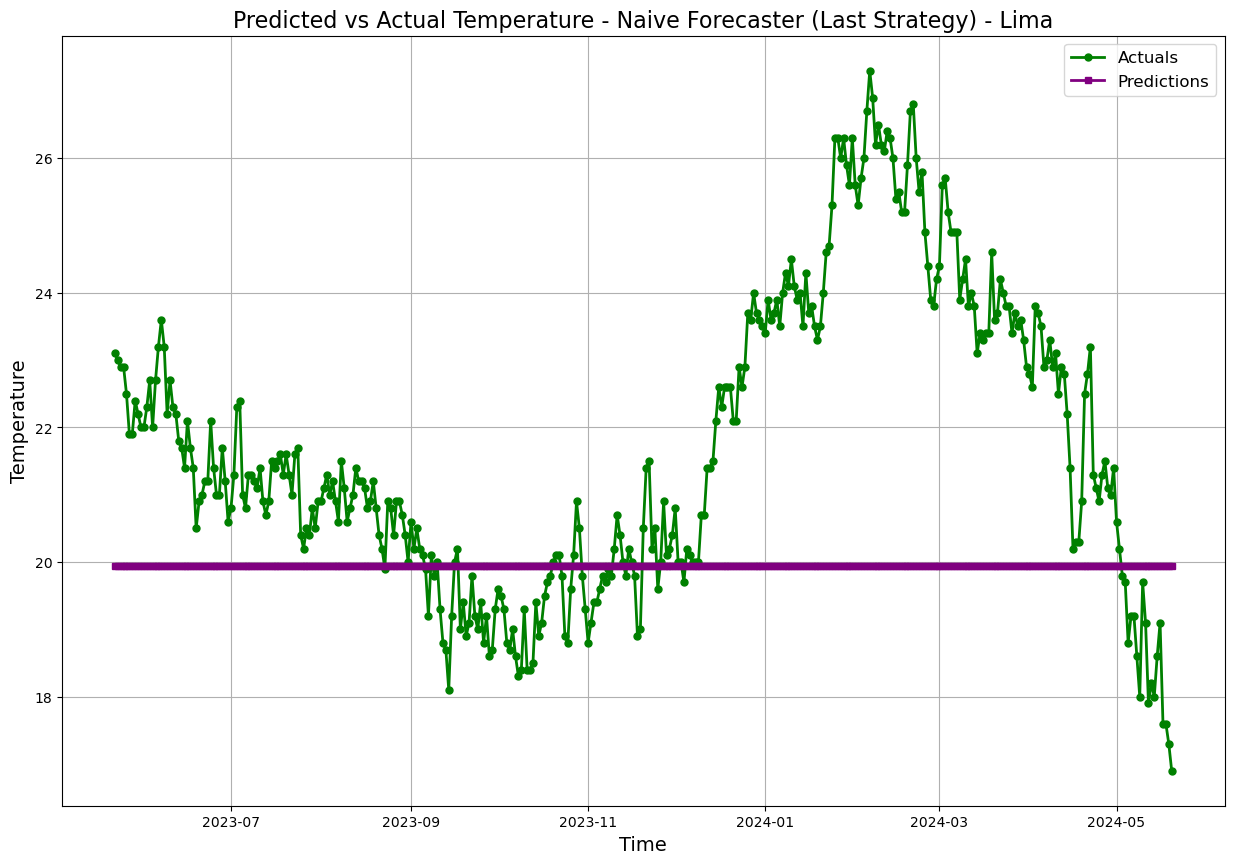

In [79]:
plt.figure(figsize=(15, 10))
plt.plot(df_test['temp'], label='Actuals', color='green', marker='o', markersize=5, linestyle='-', linewidth=2)
plt.plot(y_pred_naiveforecaster_gs, label='Predictions', color='purple', marker='s', markersize=5, linestyle='-', linewidth=2)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.title('Predicted vs Actual Temperature - Naive Forecaster (Last Strategy) - Lima', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [80]:
df_preds_lima

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,xgb_base_lima,xgb_gs_lima,naive_base_lima,naive_gs_lima
2023-05-22,23.1,17.0,70.9,0.1,100.0,4.17,0.0,0.0,13.3,27.7,152.5,1012.9,99.2,10.0,191.1,16.5,8.0,10.0,0.00,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.204420,22.007751,19.945401,19.945401
2023-05-23,23.0,16.9,69.7,0.1,100.0,4.17,0.0,0.0,9.0,25.9,160.7,1012.8,99.2,10.0,192.5,16.5,8.0,10.0,0.03,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.350317,22.109001,19.945401,19.945401
2023-05-24,22.9,17.3,73.6,0.0,0.0,0.00,0.0,0.0,10.8,24.1,161.1,1012.6,97.1,10.0,179.6,15.5,8.0,10.0,0.07,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.709921,22.018497,19.945401,19.945401
2023-05-25,22.9,17.5,70.9,0.1,100.0,4.17,0.0,0.0,9.0,24.1,161.0,1012.4,97.5,9.5,151.9,13.2,7.0,10.0,0.10,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.468319,22.425869,19.945401,19.945401
2023-05-26,22.5,17.8,72.6,0.1,100.0,4.17,0.0,0.0,11.2,25.9,161.7,1013.0,96.7,10.0,183.7,15.8,7.0,10.0,0.13,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.856779,22.813673,19.945401,19.945401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,19.1,15.5,84.8,0.0,0.0,0.00,0.0,0.0,6.8,14.8,229.6,1011.8,73.7,7.0,228.2,19.8,9.0,10.0,0.18,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,18.375383,18.270029,19.945401,19.945401
2024-05-17,17.6,15.2,83.7,0.0,0.0,0.00,0.0,0.0,8.3,18.4,288.0,1012.0,75.8,9.1,229.0,19.8,8.0,10.0,0.21,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,18.531572,18.061329,19.945401,19.945401
2024-05-18,17.6,15.4,81.5,0.0,0.0,0.00,0.0,0.0,9.7,18.4,194.4,1013.6,73.6,9.0,240.5,20.9,8.0,10.0,0.25,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,18.570539,18.788651,19.945401,19.945401
2024-05-19,17.3,15.9,82.3,0.0,0.0,0.00,0.0,0.0,11.5,20.5,175.4,1013.1,49.1,7.5,237.9,20.6,8.0,10.0,0.28,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,19.060915,18.965546,19.945401,19.945401


## Auto-ARIMA

In [81]:
df_train_short = df_train[df_train.index > pd.to_datetime('2021-01-01')]

In [82]:
start_time = time.time()

forecaster_arima = AutoARIMA(sp=12, suppress_warnings=True)
forecaster_arima.fit(df_train_short['temp'])

end_time = time.time()
time_autoarima_baseline = end_time - start_time
print(f"Model execution time for Auto ARIMA: {time_autoarima_baseline:.4f} seconds")

Model execution time for Auto ARIMA: 406.1125 seconds


In [83]:
y_pred_autoarima_lima = forecaster_arima.predict(df_test.index)

In [84]:
df_preds_lima['preds_autoarima_lima'] = y_pred_autoarima_lima

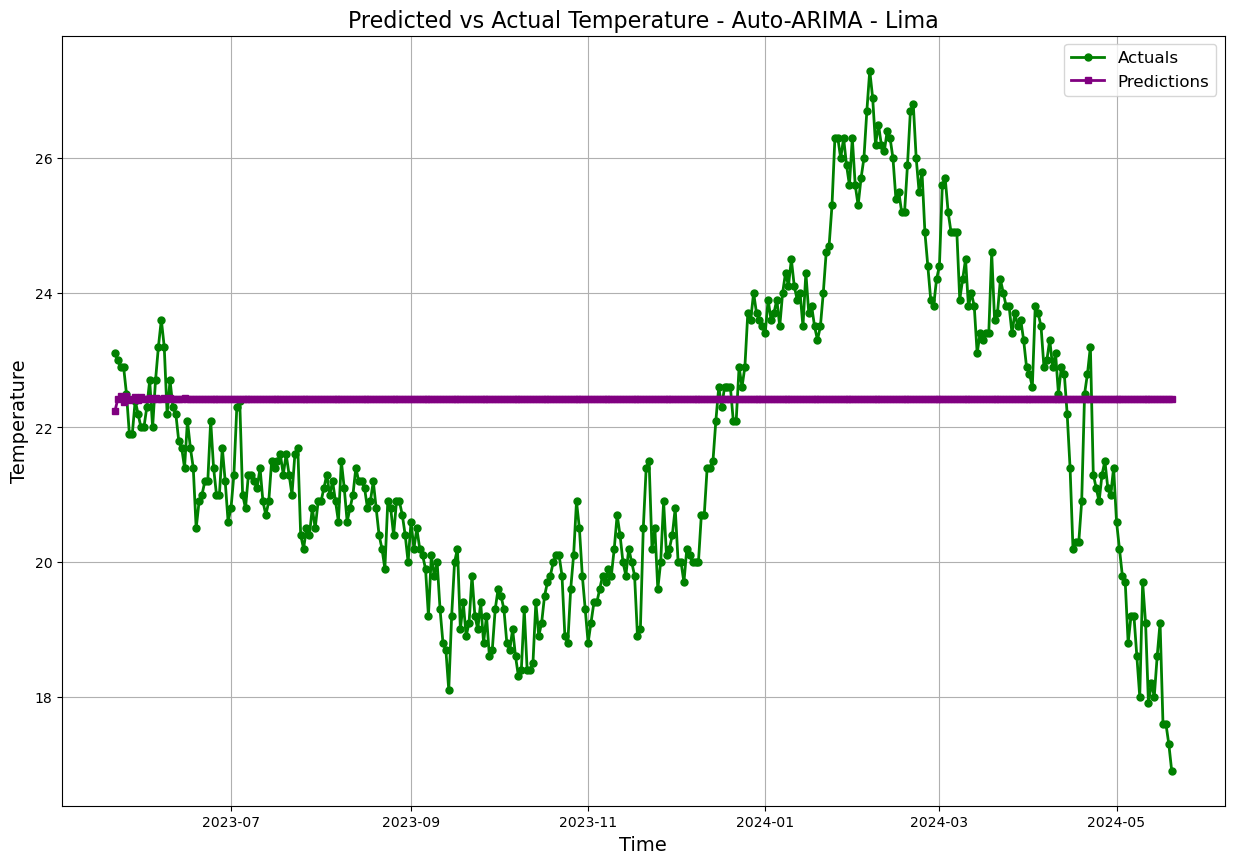

In [85]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['preds_autoarima_lima']], 'Auto-ARIMA', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

## SARIMAX

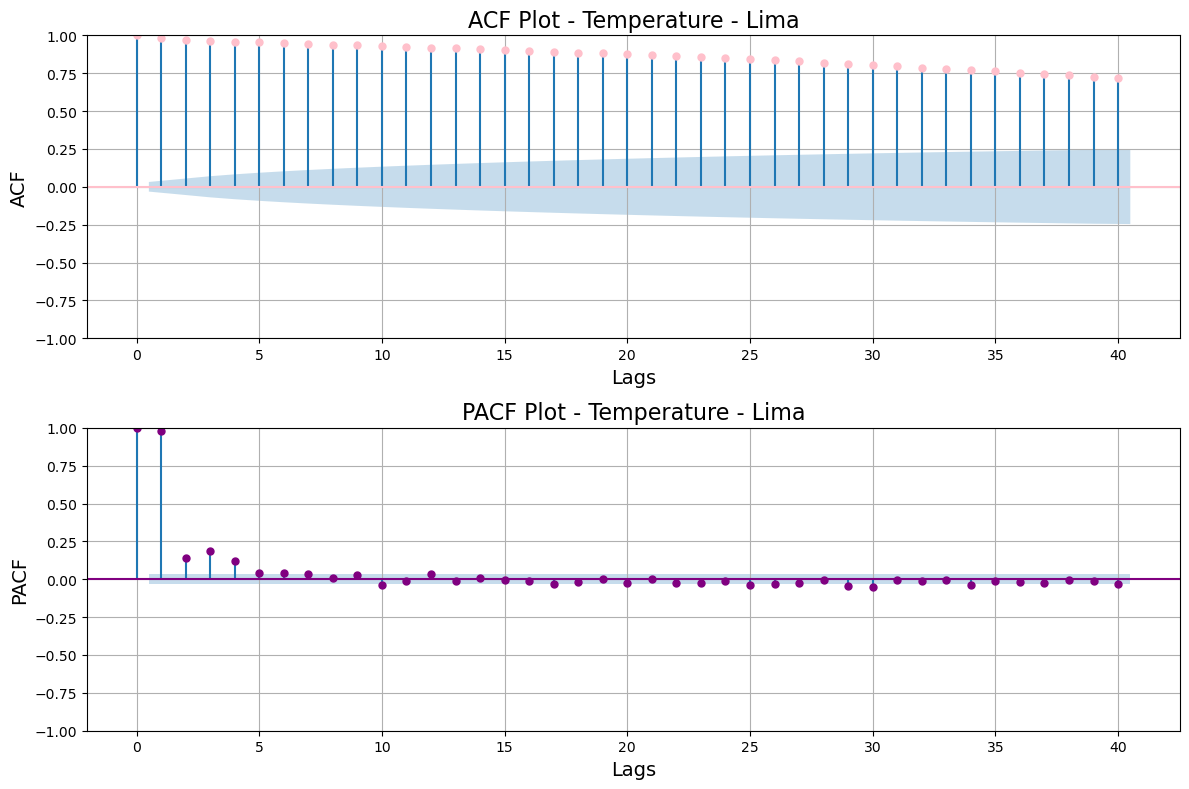

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF Plot
plot_acf(df_lima['temp'], lags=40, ax=ax[0], color='pink', title='ACF Plot', alpha=0.05)
ax[0].set_title('ACF Plot - Temperature - Lima', fontsize=16)
ax[0].set_xlabel('Lags', fontsize=14)
ax[0].set_ylabel('ACF', fontsize=14)
ax[0].grid(True)

# PACF Plot
plot_pacf(df_lima['temp'], lags=40, ax=ax[1], color='purple', title='PACF Plot', alpha=0.05)
ax[1].set_title('PACF Plot - Temperature - Lima', fontsize=16)
ax[1].set_xlabel('Lags', fontsize=14)
ax[1].set_ylabel('PACF', fontsize=14)
ax[1].grid(True)

plt.tight_layout()

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\ACF_PACF-Lima.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [87]:
start_time = time.time()
model_sarimax_baseline = StatsmodelsSARIMAX(
    endog=df_train_short['temp'],
    exog=df_train_short.drop('temp',axis=1).astype(float),
    order=(1, 1, 1),  
    seasonal_order=(2, 1, 0, 12)  
)

In [88]:
sarimax_base_results = model_sarimax_baseline.fit()

end_time = time.time()
time_sarimax_baseline = end_time - start_time
print(f"Model execution time for SARIMAX baseline: {time_sarimax_baseline:.4f} seconds")

Model execution time for SARIMAX baseline: 135.3363 seconds


In [89]:
forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))

In [90]:
forecast_sarimax.predicted_mean

2023-05-22    22.410406
2023-05-23    21.982159
2023-05-24    22.125336
2023-05-25    22.266274
2023-05-26    22.481514
                ...    
2024-05-16     6.597251
2024-05-17     6.284011
2024-05-18     6.429229
2024-05-19     6.826498
2024-05-20     7.527759
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [91]:
df_preds_lima['preds_sarimax'] = forecast_sarimax.predicted_mean
df_preds_lima.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,xgb_base_lima,xgb_gs_lima,naive_base_lima,naive_gs_lima,preds_autoarima_lima,preds_sarimax
2023-05-22,23.1,17.0,70.9,0.1,100.0,4.17,0.0,0.0,13.3,27.7,152.5,1012.9,99.2,10.0,191.1,16.5,8.0,10.0,0.00,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.204420,22.007751,19.945401,19.945401,22.238628,22.410406
2023-05-23,23.0,16.9,69.7,0.1,100.0,4.17,0.0,0.0,9.0,25.9,160.7,1012.8,99.2,10.0,192.5,16.5,8.0,10.0,0.03,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.350317,22.109001,19.945401,19.945401,22.421975,21.982159
2023-05-24,22.9,17.3,73.6,0.0,0.0,0.00,0.0,0.0,10.8,24.1,161.1,1012.6,97.1,10.0,179.6,15.5,8.0,10.0,0.07,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.709921,22.018497,19.945401,19.945401,22.465964,22.125336
2023-05-25,22.9,17.5,70.9,0.1,100.0,4.17,0.0,0.0,9.0,24.1,161.0,1012.4,97.5,9.5,151.9,13.2,7.0,10.0,0.10,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.468319,22.425869,19.945401,19.945401,22.381540,22.266274
2023-05-26,22.5,17.8,72.6,0.1,100.0,4.17,0.0,0.0,11.2,25.9,161.7,1013.0,96.7,10.0,183.7,15.8,7.0,10.0,0.13,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.856779,22.813673,19.945401,19.945401,22.466933,22.481514


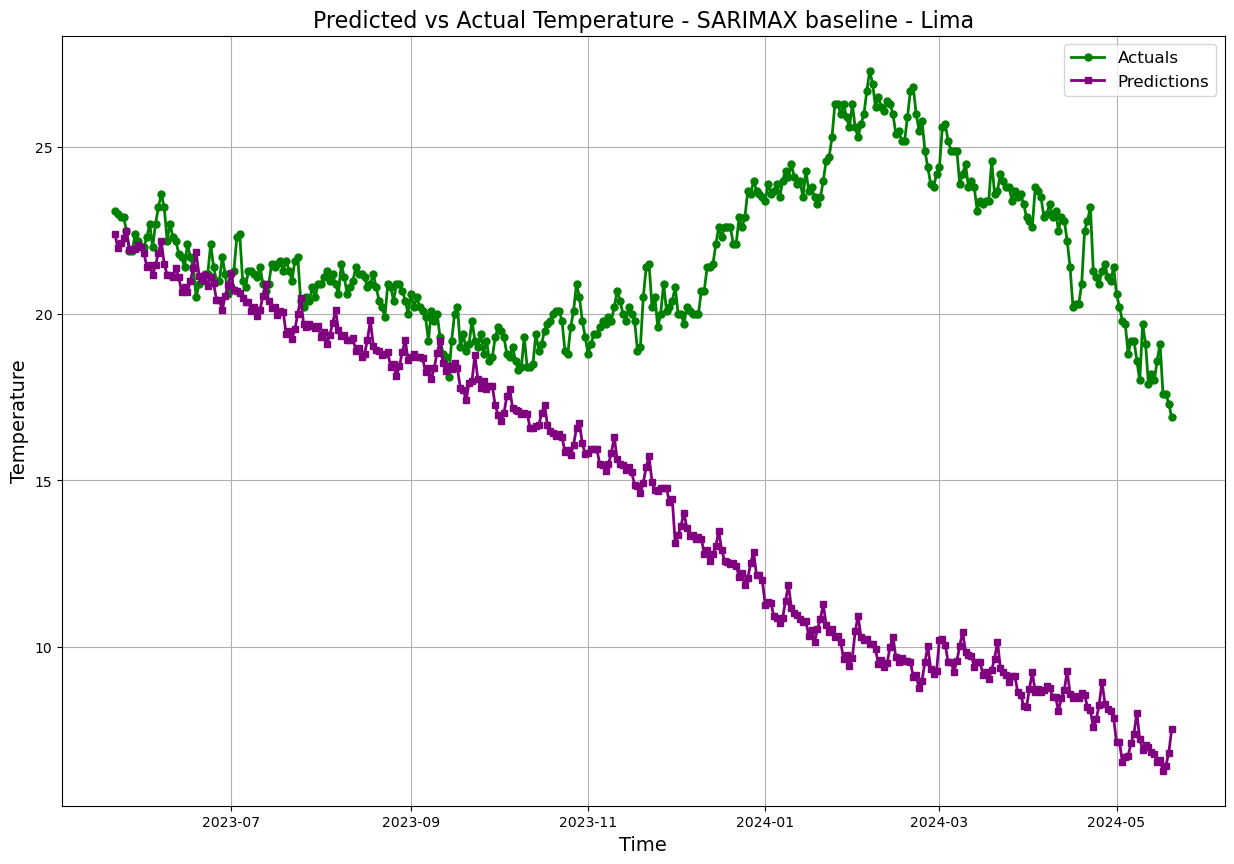

In [92]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['preds_sarimax']], 'SARIMAX baseline', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

In [93]:
mae = mean_absolute_error(df_test['temp'], df_preds_lima['preds_sarimax'])
mse = mean_squared_error(df_test['temp'], df_preds_lima['preds_sarimax'])
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], df_preds_lima['preds_sarimax'])

print(f"Mean Absolute Error (MAE) for SARIMAX: {mae}")
print(f"Mean Squared Error (MSE) for SARIMAX: {mse}")
print(f"Root Mean Squared Error (RMSE) for SARIMAX: {rmse}")
print(f"R-squared (R²) for SARIMAX: {r2}")

Mean Absolute Error (MAE) for SARIMAX: 7.251045160308472
Mean Squared Error (MSE) for SARIMAX: 88.27474496515143
Root Mean Squared Error (RMSE) for SARIMAX: 9.395464063320738
R-squared (R²) for SARIMAX: -17.3027571007009


In [94]:
sarimax_results_lima=df_preds_lima.copy()

In [95]:
def gridsearch_sarimax(p,d,q,P,D,Q,S,df_results_sarimax): 
    start_time = time.time()
    print(p,d,q,P,D,Q,S)
    model_sarimax_baseline = StatsmodelsSARIMAX(
    endog=df_train_short['temp'],
    exog=df_train_short.drop('temp',axis=1).astype(float),
    order=(p,d,q),  
    seasonal_order=(P,D,Q,S))
    sarimax_base_results = model_sarimax_baseline.fit()
    forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))
    df_results_sarimax[f"{p}_{d}_{q}_{P}_{D}_{Q}_{S}"]=forecast_sarimax.predicted_mean
    df_results_sarimax.to_csv(r"C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\sarimax_results-lima.csv")
    end_time = time.time()
    time_sarimax_gs = end_time - start_time
    print(f"Model execution time for SARIMAX grid search: {time_sarimax_gs:.4f} seconds")
    return df_results_sarimax

In [96]:
p_values = range(0, 2)
d_values = [1]
q_values = range(0, 2)
P_values = range(0, 2)
D_values = [1]
Q_values = range(0, 2)
s_values = [12]

In [97]:
for p in p_values: 
    for d in d_values:
        for q in q_values: 
            for P in P_values: 
                for D in D_values: 
                    for Q in Q_values: 
                        for s in s_values:
                            sarimax_results_lima = gridsearch_sarimax(p,d,q,P,D,Q,s,sarimax_results_lima)



0 1 0 0 1 0 12
Model execution time for SARIMAX grid search: 13.5564 seconds
0 1 0 0 1 1 12
Model execution time for SARIMAX grid search: 44.8399 seconds
0 1 0 1 1 0 12
Model execution time for SARIMAX grid search: 43.1101 seconds
0 1 0 1 1 1 12
Model execution time for SARIMAX grid search: 48.9322 seconds
0 1 1 0 1 0 12
Model execution time for SARIMAX grid search: 20.4334 seconds
0 1 1 0 1 1 12
Model execution time for SARIMAX grid search: 54.1332 seconds
0 1 1 1 1 0 12
Model execution time for SARIMAX grid search: 46.1150 seconds
0 1 1 1 1 1 12
Model execution time for SARIMAX grid search: 54.7834 seconds
1 1 0 0 1 0 12
Model execution time for SARIMAX grid search: 18.7628 seconds
1 1 0 0 1 1 12
Model execution time for SARIMAX grid search: 51.4552 seconds
1 1 0 1 1 0 12
Model execution time for SARIMAX grid search: 48.2359 seconds
1 1 0 1 1 1 12
Model execution time for SARIMAX grid search: 47.9602 seconds
1 1 1 0 1 0 12
Model execution time for SARIMAX grid search: 25.2840 seconds

In [98]:
sarimax_results_lima.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,xgb_base_lima,xgb_gs_lima,naive_base_lima,naive_gs_lima,preds_autoarima_lima,preds_sarimax,0_1_0_0_1_0_12,0_1_0_0_1_1_12,0_1_0_1_1_0_12,0_1_0_1_1_1_12,0_1_1_0_1_0_12,0_1_1_0_1_1_12,0_1_1_1_1_0_12,0_1_1_1_1_1_12,1_1_0_0_1_0_12,1_1_0_0_1_1_12,1_1_0_1_1_0_12,1_1_0_1_1_1_12,1_1_1_0_1_0_12,1_1_1_0_1_1_12,1_1_1_1_1_0_12,1_1_1_1_1_1_12
2023-05-22,23.1,17.0,70.9,0.1,100.0,4.17,0.0,0.0,13.3,27.7,152.5,1012.9,99.2,10.0,191.1,16.5,8.0,10.0,0.00,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.204420,22.007751,19.945401,19.945401,22.238628,22.410406,22.331055,22.580602,22.288422,22.610288,22.276054,22.654073,22.252849,22.653414,22.299016,22.672823,22.257931,22.662110,22.199443,22.690560,22.266309,22.669817
2023-05-23,23.0,16.9,69.7,0.1,100.0,4.17,0.0,0.0,9.0,25.9,160.7,1012.8,99.2,10.0,192.5,16.5,8.0,10.0,0.03,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.350317,22.109001,19.945401,19.945401,22.421975,21.982159,22.218808,22.400643,22.160128,22.468825,22.132717,22.531914,22.132567,22.514747,22.171805,22.572989,22.145974,22.534435,22.045153,22.604456,22.136328,22.586672
2023-05-24,22.9,17.3,73.6,0.0,0.0,0.00,0.0,0.0,10.8,24.1,161.1,1012.6,97.1,10.0,179.6,15.5,8.0,10.0,0.07,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.709921,22.018497,19.945401,19.945401,22.465964,22.125336,22.908733,22.275144,22.391132,22.236974,22.853543,22.378643,22.383163,22.233371,22.879710,22.389134,22.395016,22.238491,22.732182,22.382844,22.353501,22.282646
2023-05-25,22.9,17.5,70.9,0.1,100.0,4.17,0.0,0.0,9.0,24.1,161.0,1012.4,97.5,9.5,151.9,13.2,7.0,10.0,0.10,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.468319,22.425869,19.945401,19.945401,22.381540,22.266274,23.570199,22.431931,22.895393,22.372440,23.529649,22.554927,22.865495,22.346475,23.545758,22.585999,22.893139,22.372233,23.448653,22.629655,22.871757,22.424807
2023-05-26,22.5,17.8,72.6,0.1,100.0,4.17,0.0,0.0,11.2,25.9,161.7,1013.0,96.7,10.0,183.7,15.8,7.0,10.0,0.13,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.856779,22.813673,19.945401,19.945401,22.466933,22.481514,24.898692,22.772516,23.267052,22.542380,24.846905,22.771288,23.269717,22.438723,24.871372,22.776836,23.298911,22.470559,24.706331,22.835785,23.261130,22.570334


In [99]:
for p in p_values: 
    for d in d_values:
        for q in q_values: 
            for P in P_values: 
                for D in D_values: 
                    for Q in Q_values: 
                        for s in s_values:
                            config = f"{p}_{d}_{q}_{P}_{D}_{Q}_{s}"
                            sarimax_results_lima[f'ae_{config}'] = np.abs(sarimax_results_lima['temp'] - sarimax_results_lima[config])
                            #for each day it substracts the prediction from the actual temperature so it gets the error 

In [100]:
sarimax_results_lima.head() #with the absolute error for all combos

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,xgb_base_lima,xgb_gs_lima,naive_base_lima,naive_gs_lima,preds_autoarima_lima,preds_sarimax,0_1_0_0_1_0_12,0_1_0_0_1_1_12,0_1_0_1_1_0_12,0_1_0_1_1_1_12,0_1_1_0_1_0_12,0_1_1_0_1_1_12,0_1_1_1_1_0_12,0_1_1_1_1_1_12,1_1_0_0_1_0_12,1_1_0_0_1_1_12,1_1_0_1_1_0_12,1_1_0_1_1_1_12,1_1_1_0_1_0_12,1_1_1_0_1_1_12,1_1_1_1_1_0_12,1_1_1_1_1_1_12,ae_0_1_0_0_1_0_12,ae_0_1_0_0_1_1_12,ae_0_1_0_1_1_0_12,ae_0_1_0_1_1_1_12,ae_0_1_1_0_1_0_12,ae_0_1_1_0_1_1_12,ae_0_1_1_1_1_0_12,ae_0_1_1_1_1_1_12,ae_1_1_0_0_1_0_12,ae_1_1_0_0_1_1_12,ae_1_1_0_1_1_0_12,ae_1_1_0_1_1_1_12,ae_1_1_1_0_1_0_12,ae_1_1_1_0_1_1_12,ae_1_1_1_1_1_0_12,ae_1_1_1_1_1_1_12
2023-05-22,23.1,17.0,70.9,0.1,100.0,4.17,0.0,0.0,13.3,27.7,152.5,1012.9,99.2,10.0,191.1,16.5,8.0,10.0,0.00,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.204420,22.007751,19.945401,19.945401,22.238628,22.410406,22.331055,22.580602,22.288422,22.610288,22.276054,22.654073,22.252849,22.653414,22.299016,22.672823,22.257931,22.662110,22.199443,22.690560,22.266309,22.669817,0.768945,0.519398,0.811578,0.489712,0.823946,0.445927,0.847151,0.446586,0.800984,0.427177,0.842069,0.437890,0.900557,0.409440,0.833691,0.430183
2023-05-23,23.0,16.9,69.7,0.1,100.0,4.17,0.0,0.0,9.0,25.9,160.7,1012.8,99.2,10.0,192.5,16.5,8.0,10.0,0.03,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.350317,22.109001,19.945401,19.945401,22.421975,21.982159,22.218808,22.400643,22.160128,22.468825,22.132717,22.531914,22.132567,22.514747,22.171805,22.572989,22.145974,22.534435,22.045153,22.604456,22.136328,22.586672,0.781192,0.599357,0.839872,0.531175,0.867283,0.468086,0.867433,0.485253,0.828195,0.427011,0.854026,0.465565,0.954847,0.395544,0.863672,0.413328
2023-05-24,22.9,17.3,73.6,0.0,0.0,0.00,0.0,0.0,10.8,24.1,161.1,1012.6,97.1,10.0,179.6,15.5,8.0,10.0,0.07,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.709921,22.018497,19.945401,19.945401,22.465964,22.125336,22.908733,22.275144,22.391132,22.236974,22.853543,22.378643,22.383163,22.233371,22.879710,22.389134,22.395016,22.238491,22.732182,22.382844,22.353501,22.282646,0.008733,0.624856,0.508868,0.663026,0.046457,0.521357,0.516837,0.666629,0.020290,0.510866,0.504984,0.661509,0.167818,0.517156,0.546499,0.617354
2023-05-25,22.9,17.5,70.9,0.1,100.0,4.17,0.0,0.0,9.0,24.1,161.0,1012.4,97.5,9.5,151.9,13.2,7.0,10.0,0.10,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.468319,22.425869,19.945401,19.945401,22.381540,22.266274,23.570199,22.431931,22.895393,22.372440,23.529649,22.554927,22.865495,22.346475,23.545758,22.585999,22.893139,22.372233,23.448653,22.629655,22.871757,22.424807,0.670199,0.468069,0.004607,0.527560,0.629649,0.345073,0.034505,0.553525,0.645758,0.314001,0.006861,0.527767,0.548653,0.270345,0.028243,0.475193
2023-05-26,22.5,17.8,72.6,0.1,100.0,4.17,0.0,0.0,11.2,25.9,161.7,1013.0,96.7,10.0,183.7,15.8,7.0,10.0,0.13,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.856779,22.813673,19.945401,19.945401,22.466933,22.481514,24.898692,22.772516,23.267052,22.542380,24.846905,22.771288,23.269717,22.438723,24.871372,22.776836,23.298911,22.470559,24.706331,22.835785,23.261130,22.570334,2.398692,0.272516,0.767052,0.042380,2.346905,0.271288,0.769717,0.061277,2.371372,0.276836,0.798911,0.029441,2.206331,0.335785,0.761130,0.070334


In [101]:
sarimax_results_lima.mean()

temp                 21.714247
dew                  17.133699
humidity             75.400822
precip                0.057260
precipprob           30.136986
                       ...    
ae_1_1_0_1_1_1_12     4.688272
ae_1_1_1_0_1_0_12     9.546658
ae_1_1_1_0_1_1_12     3.747424
ae_1_1_1_1_1_0_12     4.215160
ae_1_1_1_1_1_1_12     4.579319
Length: 71, dtype: float64

In [102]:
sarimax_results_lima.iloc[:, -16:].mean()

ae_0_1_0_0_1_0_12    13.565188
ae_0_1_0_0_1_1_12     4.788789
ae_0_1_0_1_1_0_12     4.000319
ae_0_1_0_1_1_1_12     5.033302
ae_0_1_1_0_1_0_12    12.936302
ae_0_1_1_0_1_1_12     3.874918
ae_0_1_1_1_1_0_12     3.964156
ae_0_1_1_1_1_1_12     4.736288
ae_1_1_0_0_1_0_12    13.264168
ae_1_1_0_0_1_1_12     3.651114
ae_1_1_0_1_1_0_12     3.748311
ae_1_1_0_1_1_1_12     4.688272
ae_1_1_1_0_1_0_12     9.546658
ae_1_1_1_0_1_1_12     3.747424
ae_1_1_1_1_1_0_12     4.215160
ae_1_1_1_1_1_1_12     4.579319
dtype: float64

## LSTM 

In [103]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df_lima[['temp']])

In [104]:
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

def split_sequence(sequence, n_steps):
    xs, ys = [], []
    for i in range(len(sequence) - n_steps):
        x = sequence[i:i + n_steps]
        y = sequence[i + n_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [105]:
n_steps = 30
X_train, y_train= split_sequence(values, n_steps)
X_test, y_test = split_sequence(values, n_steps)

In [106]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [107]:
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [108]:
model_baseline = Sequential()
model_baseline.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model_baseline.add(LSTM(50))
model_baseline.add(Dense(1))
model_baseline.compile(optimizer='adam', loss='mean_squared_error')

In [109]:
start_time = time.time()

model_baseline.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

end_time = time.time()
time_lstm_baseline = end_time - start_time
print(f"Model training time for LSTM baseline: {time_lstm_baseline:.2f} seconds")

Epoch 1/10
118/118 [==============================] - 34s 78ms/step - loss: 0.0157 - val_loss: 0.0046
Epoch 2/10
118/118 [==============================] - 6s 55ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 3/10
118/118 [==============================] - 8s 68ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/10
118/118 [==============================] - 6s 50ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/10
118/118 [==============================] - 6s 54ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/10
118/118 [==============================] - 6s 50ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/10
118/118 [==============================] - 8s 56ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/10
118/118 [==============================] - 6s 49ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 9/10
118/118 [==============================] - 6s 50ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 10/10
118/118 [==============================] - 6s 51ms/step - loss: 0.0023 - val_l

In [110]:
def predict_future(model, data, n_steps, predict_n_days):
    prediction_list = data[-n_steps:].tolist()
    prediction_list = [item[0] for item in prediction_list]
    
    for _ in range(predict_n_days):
        x = np.array(prediction_list[-n_steps:]).reshape((1, n_steps, 1))
        out = model.predict(x)[0][0]
        prediction_list.append(out)

    # transforms the predictions back to the original scale
    prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape(-1, 1))
    return prediction_list

In [111]:
predict_n_days = 365

In [112]:
yhat_baseline = predict_future(model_baseline, values, n_steps, predict_n_days)

1/1 [==============================] - 0s 31ms/step


In [113]:
yhat_baseline[n_steps:]

array([[17.5320167 ],
       [17.45707501],
       [17.43885004],
       [17.43939453],
       [17.44713227],
       [17.45633788],
       [17.46585235],
       [17.4748901 ],
       [17.4826209 ],
       [17.49049946],
       [17.49974694],
       [17.50885604],
       [17.51961758],
       [17.53183383],
       [17.5460707 ],
       [17.56150263],
       [17.57965813],
       [17.60005391],
       [17.62154806],
       [17.64382628],
       [17.67058356],
       [17.69760033],
       [17.72440549],
       [17.75246449],
       [17.78103623],
       [17.81156288],
       [17.8434286 ],
       [17.87346277],
       [17.9040786 ],
       [17.93458986],
       [17.96479282],
       [17.99642553],
       [18.02796061],
       [18.06027957],
       [18.09233379],
       [18.12527046],
       [18.15807757],
       [18.19124293],
       [18.22496178],
       [18.25934454],
       [18.2939019 ],
       [18.32827602],
       [18.3626768 ],
       [18.39834304],
       [18.43399464],
       [18

In [114]:
len(yhat_baseline[n_steps:])

365

In [115]:
df_preds_lima['lstm_base'] = yhat_baseline[n_steps:]
df_preds_lima.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,xgb_base_lima,xgb_gs_lima,naive_base_lima,naive_gs_lima,preds_autoarima_lima,preds_sarimax,lstm_base
2023-05-22,23.1,17.0,70.9,0.1,100.0,4.17,0.0,0.0,13.3,27.7,152.5,1012.9,99.2,10.0,191.1,16.5,8.0,10.0,0.00,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.204420,22.007751,19.945401,19.945401,22.238628,22.410406,17.532017
2023-05-23,23.0,16.9,69.7,0.1,100.0,4.17,0.0,0.0,9.0,25.9,160.7,1012.8,99.2,10.0,192.5,16.5,8.0,10.0,0.03,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.350317,22.109001,19.945401,19.945401,22.421975,21.982159,17.457075
2023-05-24,22.9,17.3,73.6,0.0,0.0,0.00,0.0,0.0,10.8,24.1,161.1,1012.6,97.1,10.0,179.6,15.5,8.0,10.0,0.07,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.709921,22.018497,19.945401,19.945401,22.465964,22.125336,17.438850
2023-05-25,22.9,17.5,70.9,0.1,100.0,4.17,0.0,0.0,9.0,24.1,161.0,1012.4,97.5,9.5,151.9,13.2,7.0,10.0,0.10,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.468319,22.425869,19.945401,19.945401,22.381540,22.266274,17.439395
2023-05-26,22.5,17.8,72.6,0.1,100.0,4.17,0.0,0.0,11.2,25.9,161.7,1013.0,96.7,10.0,183.7,15.8,7.0,10.0,0.13,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.856779,22.813673,19.945401,19.945401,22.466933,22.481514,17.447132


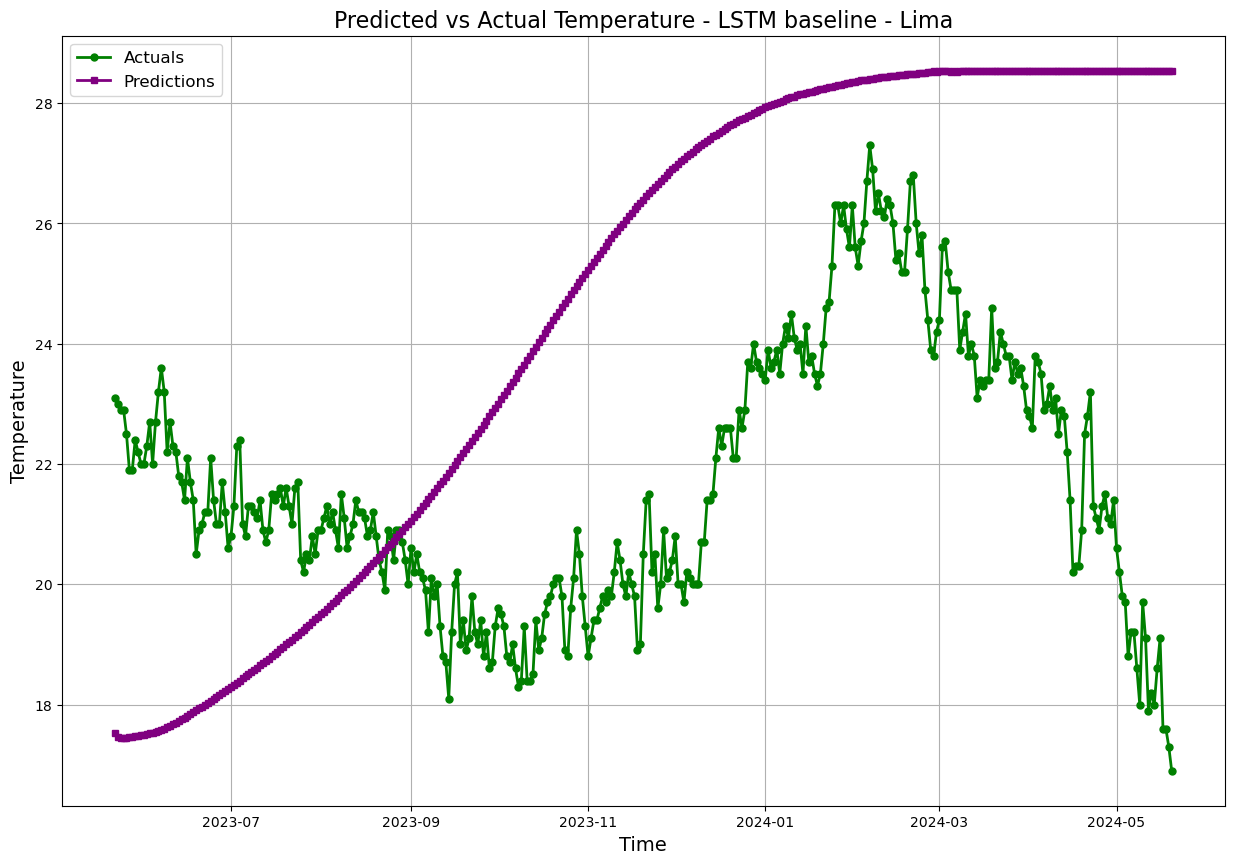

In [116]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['lstm_base']], 'LSTM baseline', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

In [117]:
y_true = df_preds_lima['temp'].values  
y_pred = df_preds_lima['lstm_base'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared Score (R²): {r2:.2f}')

Mean Absolute Error (MAE): 4.31
Mean Squared Error (MSE): 23.70
Root Mean Squared Error (RMSE): 4.87
Mean Absolute Percentage Error (MAPE): 20.39%
R-squared Score (R²): -3.91


In [118]:
model_lstm_two = Sequential()
model_lstm_two.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(LSTM(100, return_sequences=False))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(Dense(50, activation='relu'))

model_lstm_two.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm_two.compile(optimizer=optimizer, loss='mean_squared_error')

start_time = time.time()
history = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_layers = end_time - start_time
print(f"Model training time: {time_lstm_layers:.2f} seconds")

Epoch 1/3
118/118 [==============================] - 13s 50ms/step - loss: 0.0125 - val_loss: 0.0045
Epoch 2/3
118/118 [==============================] - 8s 64ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 3/3
118/118 [==============================] - 6s 52ms/step - loss: 0.0039 - val_loss: 0.0038
Model training time: 26.75 seconds


In [119]:
yhat_lstm_two = predict_future(model_lstm_two, values, n_steps, predict_n_days)

1/1 [==============================] - 0s 24ms/step


In [120]:
df_preds_lima['lstm_two_layers'] = yhat_lstm_two[n_steps:]
df_preds_lima.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,xgb_base_lima,xgb_gs_lima,naive_base_lima,naive_gs_lima,preds_autoarima_lima,preds_sarimax,lstm_base,lstm_two_layers
2023-05-22,23.1,17.0,70.9,0.1,100.0,4.17,0.0,0.0,13.3,27.7,152.5,1012.9,99.2,10.0,191.1,16.5,8.0,10.0,0.00,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.204420,22.007751,19.945401,19.945401,22.238628,22.410406,17.532017,17.659163
2023-05-23,23.0,16.9,69.7,0.1,100.0,4.17,0.0,0.0,9.0,25.9,160.7,1012.8,99.2,10.0,192.5,16.5,8.0,10.0,0.03,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.350317,22.109001,19.945401,19.945401,22.421975,21.982159,17.457075,17.522882
2023-05-24,22.9,17.3,73.6,0.0,0.0,0.00,0.0,0.0,10.8,24.1,161.1,1012.6,97.1,10.0,179.6,15.5,8.0,10.0,0.07,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.709921,22.018497,19.945401,19.945401,22.465964,22.125336,17.438850,17.422588
2023-05-25,22.9,17.5,70.9,0.1,100.0,4.17,0.0,0.0,9.0,24.1,161.0,1012.4,97.5,9.5,151.9,13.2,7.0,10.0,0.10,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.468319,22.425869,19.945401,19.945401,22.381540,22.266274,17.439395,17.344427
2023-05-26,22.5,17.8,72.6,0.1,100.0,4.17,0.0,0.0,11.2,25.9,161.7,1013.0,96.7,10.0,183.7,15.8,7.0,10.0,0.13,2.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,22.856779,22.813673,19.945401,19.945401,22.466933,22.481514,17.447132,17.280555


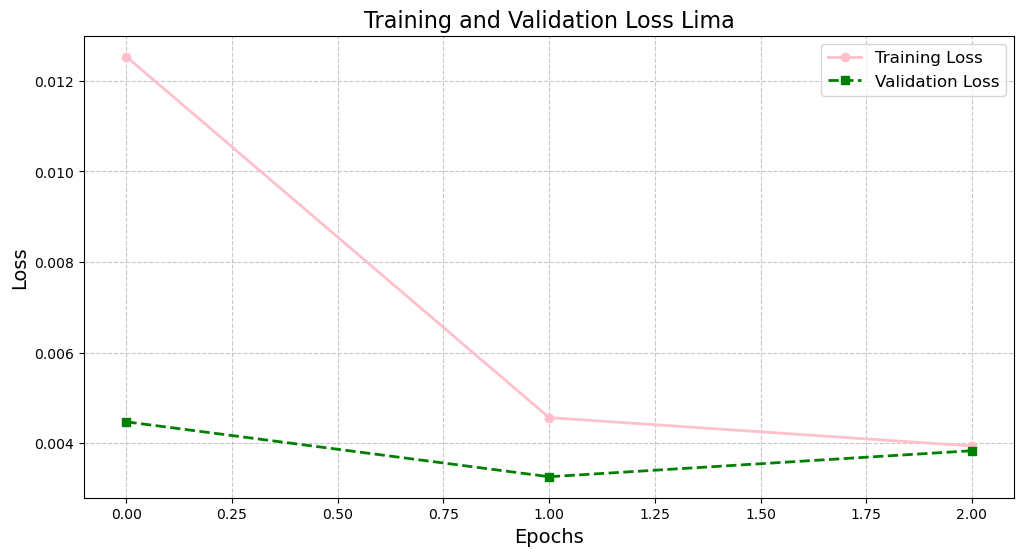

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='pink', linestyle='-', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green', linestyle='--', linewidth=2, marker='s')
plt.title('Training and Validation Loss Lima', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\LSTM_baseline_training_loss-Lima.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

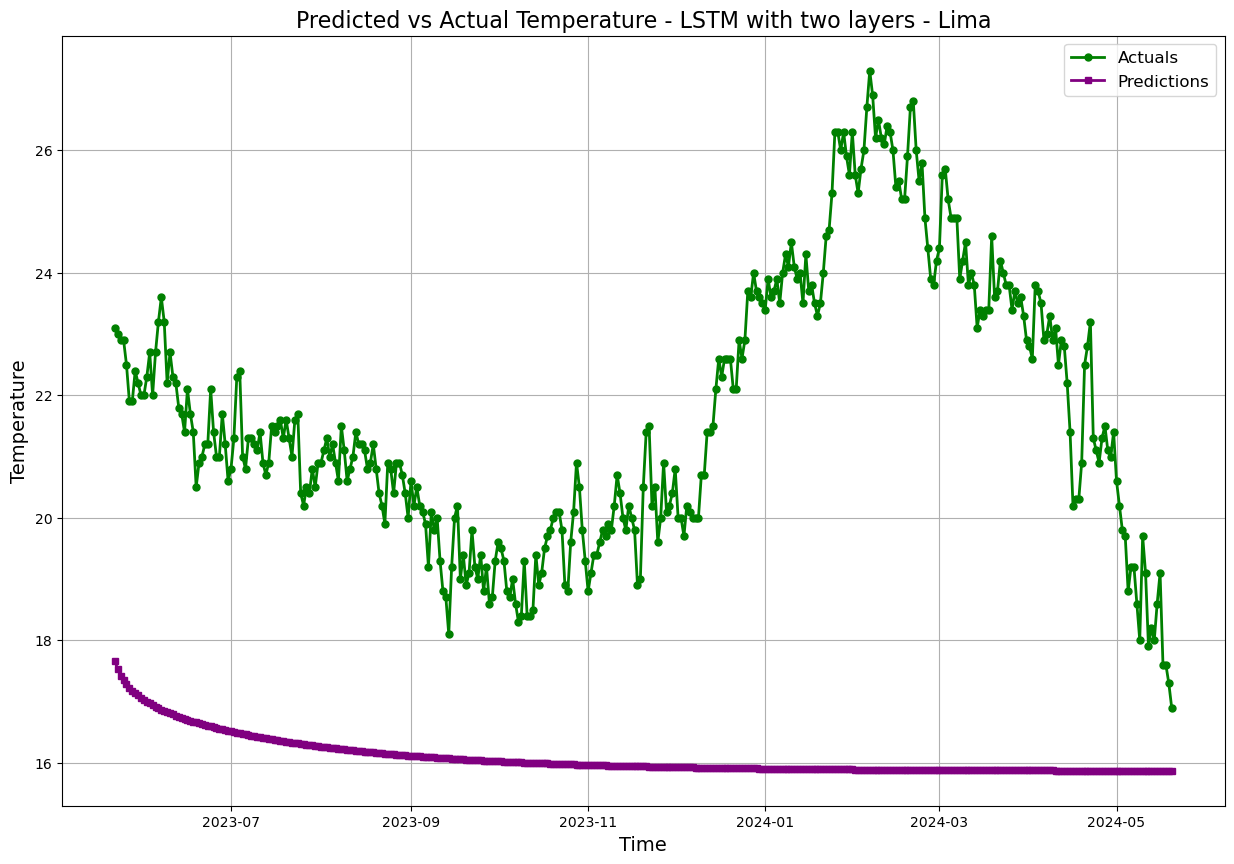

In [122]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['lstm_two_layers']], 'LSTM with two layers', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

In [123]:
y_true = df_preds_lima['temp'].values
y_pred_lstm_two = df_preds_lima['lstm_two_layers'].values

mae_value_lstm_two = mean_absolute_error(y_true, y_pred_lstm_two)
mse_value_lstm_two = mean_squared_error(y_true, y_pred_lstm_two)
rmse_value_lstm_two = np.sqrt(mse_value_lstm_two)
mape_value_lstm_two = np.mean(np.abs((y_true - y_pred_lstm_two) / y_true)) * 100
r2_value_lstm_two = r2_score(y_true, y_pred_lstm_two)

print(f'Mean Absolute Error (MAE): {mae_value_lstm_two:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_two:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_two:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_two:.2f}%')
print(f'R-squared Score (R²): {r2_value_lstm_two:.2f}')

Mean Absolute Error (MAE): 5.62
Mean Squared Error (MSE): 36.67
Root Mean Squared Error (RMSE): 6.06
Mean Absolute Percentage Error (MAPE): 25.15%
R-squared Score (R²): -6.60


In [124]:
start_time = time.time()
history_batchsize_1 = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=1, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_batch = end_time - start_time
print(f"Model training time for LSTM batch: {time_lstm_batch:.2f} seconds")

Epoch 1/3
3763/3763 [==============================] - 208s 55ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 2/3
3763/3763 [==============================] - 181s 48ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 3/3
3763/3763 [==============================] - 83s 22ms/step - loss: 0.0031 - val_loss: 0.0027
Model training time for LSTM batch: 471.64 seconds


In [125]:
yhat_lstm_batch_1 = predict_future(model_lstm_two, values, n_steps, predict_n_days)


1/1 [==============================] - 0s 39ms/step


In [126]:
df_preds_lima['lstm_two_layers_batch_size_1'] = yhat_lstm_batch_1[n_steps:]


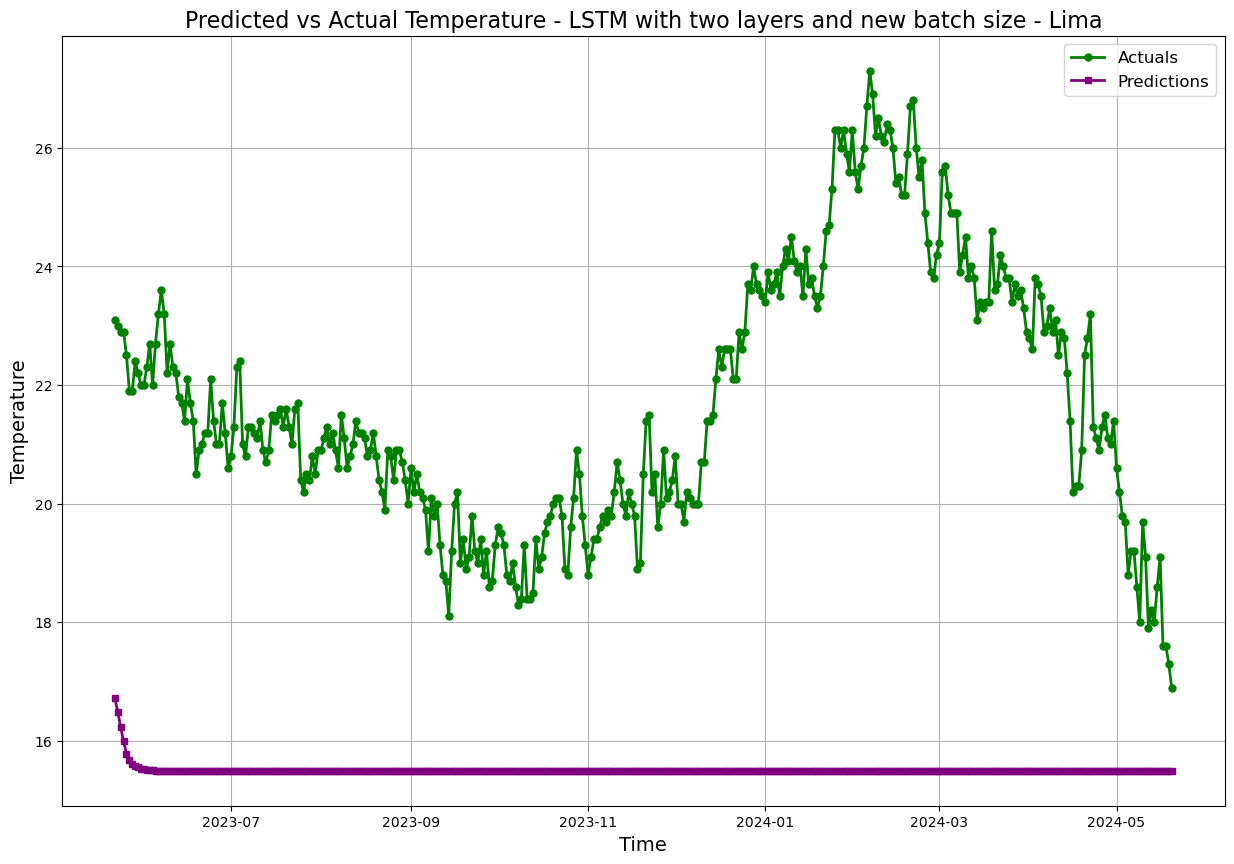

In [127]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['lstm_two_layers_batch_size_1']], 'LSTM with two layers and new batch size', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

In [128]:
y_true = df_preds_lima['temp'].values 
y_pred_lstm_batch_1 = df_preds_lima['lstm_two_layers_batch_size_1'].values

mae_value_lstm_batch_1 = mean_absolute_error(y_true, y_pred_lstm_batch_1)
mse_value_lstm_batch_1 = mean_squared_error(y_true, y_pred_lstm_batch_1)
rmse_value_lstm_batch_1 = np.sqrt(mse_value_lstm_batch_1)
mape_value_lstm_batch_1 = np.mean(np.abs((y_true - y_pred_lstm_batch_1) / y_true)) * 100
r2_value_lstm_batch_1 = r2_score(y_true, y_pred_lstm_batch_1)

print(f'Mean Absolute Error (MAE): {mae_value_lstm_batch_1:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_batch_1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_batch_1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_batch_1:.2f}%')
print(f'R-squared Score (R²): {r2_value_lstm_batch_1:.2f}')

Mean Absolute Error (MAE): 6.20
Mean Squared Error (MSE): 43.30
Root Mean Squared Error (RMSE): 6.58
Mean Absolute Percentage Error (MAPE): 27.86%
R-squared Score (R²): -7.98


In [129]:
def split_sequence(features, target, n_steps):
    xs, ys = [], []
    
    # loop through the data to create sequences
    for i in range(len(features) - n_steps):
        # extract sequences of features and the corresponding target
        x = features[i:i + n_steps]
        y = target[i + n_steps]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)


In [130]:
df_train = df_train.astype(float)
df_test = df_test.astype(float)

In [131]:
X_train, y_train= split_sequence(df_train.drop(['temp'], axis=1),df_train['temp'], n_steps)
X_test, y_test = split_sequence(df_test.drop(['temp'], axis=1),df_test['temp'], n_steps)

In [132]:
model_lstm_features = Sequential()
model_lstm_features.add(LSTM(100, return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model_lstm_features.add(Dropout(0.2))

model_lstm_features.add(LSTM(100, return_sequences=False))
model_lstm_features.add(Dropout(0.2))

model_lstm_features.add(Dense(50, activation='relu'))

model_lstm_features.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm_features.compile(optimizer=optimizer, loss='mean_squared_error')

start_time = time.time()
history = model_lstm_features.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_features = end_time - start_time
print(f"Model training time for LSTM with features: {time_lstm_features:.2f} seconds")

Epoch 1/3
107/107 [==============================] - 6s 22ms/step - loss: 59.2335 - val_loss: 8.8029
Epoch 2/3
107/107 [==============================] - 1s 14ms/step - loss: 9.7983 - val_loss: 7.9966
Epoch 3/3
107/107 [==============================] - 2s 15ms/step - loss: 9.8424 - val_loss: 8.5650
Model training time for LSTM with features: 8.66 seconds


In [133]:
def get_predictions(model, X_test):
    predictions = model.predict(X_test)
    
    # since the model outputs a 2D array (batch_size, 1), we'll flatten it to match the shape of the y_test
    return predictions.flatten()


In [134]:
preds = np.concatenate([X_train[-30:], X_test])

In [135]:
predictions = get_predictions(model_lstm_features, preds)


12/12 [==============================] - 1s 6ms/step


In [136]:
df_preds_lima['temp'].values

array([23.1, 23. , 22.9, 22.9, 22.5, 21.9, 21.9, 22.4, 22.2, 22. , 22. ,
       22.3, 22.7, 22. , 22.7, 23.2, 23.6, 23.2, 22.2, 22.7, 22.3, 22.2,
       21.8, 21.7, 21.4, 22.1, 21.7, 21.4, 20.5, 20.9, 21. , 21.2, 21.2,
       22.1, 21.4, 21. , 21. , 21.7, 21.2, 20.6, 20.8, 21.3, 22.3, 22.4,
       21. , 20.8, 21.3, 21.3, 21.2, 21.1, 21.4, 20.9, 20.7, 20.9, 21.5,
       21.4, 21.5, 21.6, 21.3, 21.6, 21.3, 21. , 21.6, 21.7, 20.4, 20.2,
       20.5, 20.4, 20.8, 20.5, 20.9, 20.9, 21.1, 21.3, 21. , 21.2, 20.9,
       20.6, 21.5, 21.1, 20.6, 20.8, 21. , 21.4, 21.2, 21.2, 21.1, 20.8,
       20.9, 21.2, 20.8, 20.4, 20.2, 19.9, 20.9, 20.8, 20.4, 20.9, 20.9,
       20.7, 20.4, 20. , 20.6, 20.2, 20.5, 20.2, 20.1, 19.9, 19.2, 20.1,
       19.8, 20. , 19.3, 18.8, 18.7, 18.1, 19.2, 20. , 20.2, 19. , 19.4,
       18.9, 19.1, 19.8, 19.2, 19. , 19.4, 18.8, 19.2, 18.6, 18.7, 19.3,
       19.6, 19.5, 19.3, 18.8, 18.7, 19. , 18.6, 18.3, 18.4, 19.3, 18.4,
       18.4, 18.5, 19.4, 18.9, 19.1, 19.5, 19.7, 19

In [137]:
df_preds_lima['lstm_features'] = predictions

In [138]:
df_preds_lima[['temp','lstm_features']]

,temp,lstm_features
2023-05-22,23.1,19.816582
2023-05-23,23.0,19.816425
2023-05-24,22.9,19.818361
2023-05-25,22.9,19.854683
2023-05-26,22.5,19.821148
...,...,...
2024-05-16,19.1,19.824127
2024-05-17,17.6,19.817764
2024-05-18,17.6,19.859329
2024-05-19,17.3,19.821041


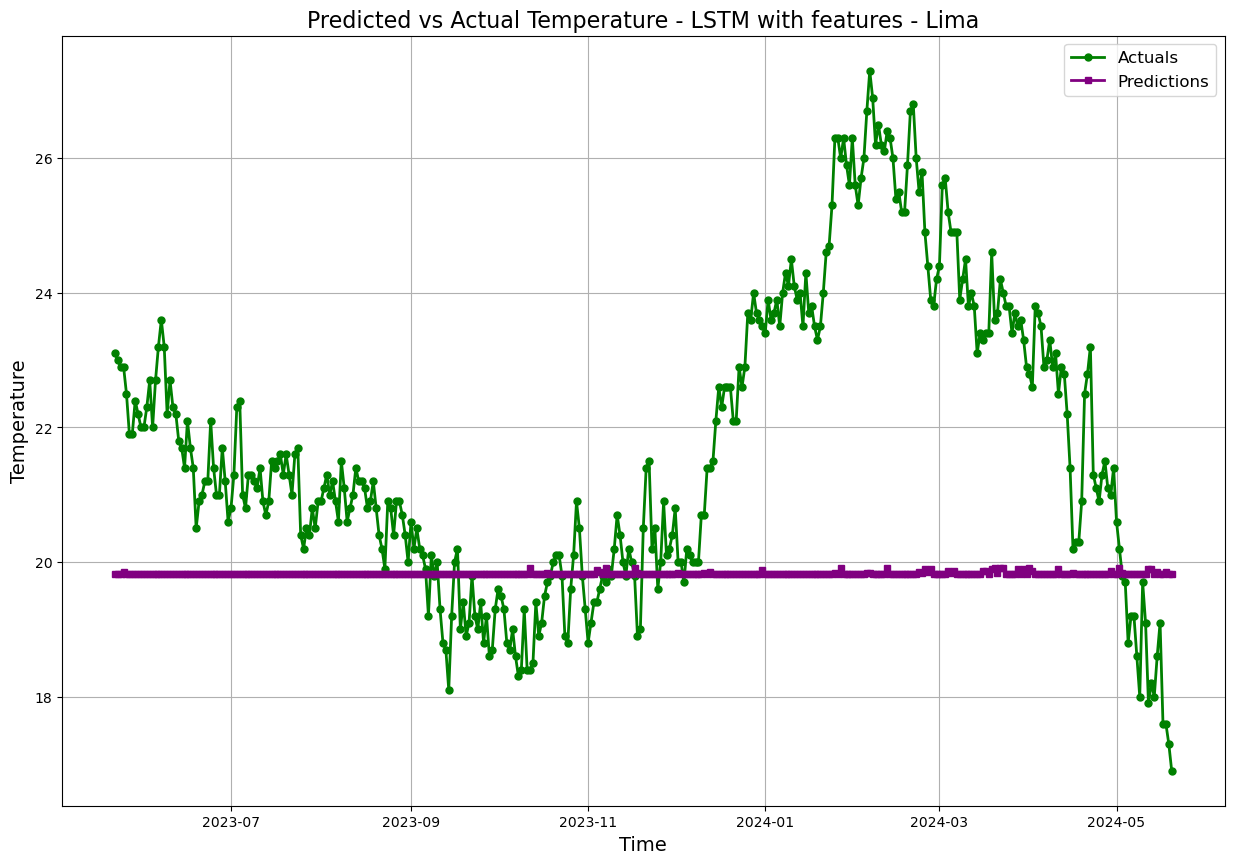

In [139]:
plot_forecast(df_preds_lima[['temp']], df_preds_lima[['lstm_features']], 'LSTM with features', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

In [140]:
y_true = df_preds_lima['temp'].values  
y_pred_lstm_features = df_preds_lima['lstm_features'].values

mae_value_lstm_features = mean_absolute_error(y_true, y_pred_lstm_features)
mse_value_lstm_features = mean_squared_error(y_true, y_pred_lstm_features)
rmse_value_lstm_features = np.sqrt(mse_value_lstm_features)
mape_value_lstm_features = np.mean(np.abs((y_true - y_pred_lstm_features) / y_true)) * 100
r2_value_lstm_features = r2_score(y_true, y_pred_lstm_features)

print(f'Mean Absolute Error (MAE): {mae_value_lstm_features:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_features:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_features:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_features:.2f}%')
print(f'R-squared Score (R²): {r2_value_lstm_features:.2f}')

Mean Absolute Error (MAE): 2.23
Mean Squared Error (MSE): 8.38
Root Mean Squared Error (RMSE): 2.90
Mean Absolute Percentage Error (MAPE): 9.63%
R-squared Score (R²): -0.74


## Concatenating SARIMAX gs best results with the comparison dataframe

In [141]:
df_preds_lima['sarimax_gs'] = sarimax_results_lima['ae_1_1_0_0_1_1_12']

In [142]:
df_preds_lima.to_csv(r"C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\df_with_all_preds_lima.csv")

## Time comparison for all models

In [143]:
# defining the results of the Naive Forecaster GS and the SARIMAX GS since they have multiple outputs 

time_nf_mean = 0.0142
time_nf_drift = 0.0147
time_nf_last = 0.0301

#best combination of the SARIMAX GS outputs
time_sarimax_best = 25.2167

In [144]:
execution_times = {
    'XGBoost Baseline Lima': time_xgboost_baseline, 
    'XGBoost Grid search Lima': time_xgboost_gs, 
    'Naive Forecaster Baseline Lima': time_naive_baseline_lima,
    'Naive Forecaster Mean strategy Lima': time_nf_mean,
    'Naive Forecaster Drift strategy Lima': time_nf_drift,
    'Naive Forecaster Last strategy Lima': time_nf_last,
    'Auto-ARIMA Lima': time_autoarima_baseline,
    'SARIMAX Baseline Lima': time_sarimax_baseline,
    'SARIMAX Best combination Lima': time_sarimax_best,
    'LSTM Baseline Lima': time_lstm_baseline,
    'LSTM Improved Layers Lima': time_lstm_layers,
    'LSTM Batch Size Lima': time_lstm_batch,
    'LSTM with features Lima': time_lstm_features
}

time_results_lima = pd.DataFrame(list(execution_times.items()), columns=['Model', 'Execution Time (seconds)'])

In [145]:
time_results_lima

,Model,Execution Time (seconds)
0,XGBoost Baseline Lima,0.681712
1,XGBoost Grid search Lima,71.536778
2,Naive Forecaster Baseline Lima,0.005346
3,Naive Forecaster Mean strategy Lima,0.014200
4,Naive Forecaster Drift strategy Lima,0.014700
5,Naive Forecaster Last strategy Lima,0.030100
6,Auto-ARIMA Lima,406.112500
7,SARIMAX Baseline Lima,135.336252
8,SARIMAX Best combination Lima,25.216700
9,LSTM Baseline Lima,93.941932
